# Opponent Modeling with LOLA for Adversarial Environments

Elias Mann, Max Hasenauer

In [33]:
#imports
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import tqdm
from pettingzoo.classic import tictactoe_v3, rps_v2, connect_four_v3, leduc_holdem_v4, texas_holdem_v4, hanabi_v5
from collections import namedtuple
import torch.optim as optim
import copy
import math
import os

## Environments

We are using simple adversarial environments.

In [38]:
envs = {
    'rps': rps_v2.env(render_mode='rgb_array'),
    'tictactoe': tictactoe_v3.env(render_mode='rgb_array'),
    'connect_four': connect_four_v3.env(render_mode='rgb_array')
}

## Models

### DDQN Model and Helper Functions

In [3]:
class ExponentialSchedule:
    def __init__(self, value_from, value_to, num_steps):
        """Exponential schedule from `value_from` to `value_to` in `num_steps` steps.

        $value(t) = a \exp (b t)$

        :param value_from: initial value
        :param value_to: final value
        :param num_steps: number of steps for the exponential schedule
        """
        self.value_from = value_from
        self.value_to = value_to
        self.num_steps = num_steps

        # YOUR CODE HERE:  determine the `a` and `b` parameters such that the schedule is correct
        self.a = value_to / value_from
        self.b = math.log(self.a) / (num_steps - 1)

    def value(self, step) -> float:
        """Return exponentially interpolated value between `value_from` and `value_to`interpolated value between.

        returns {
            `value_from`, if step == 0 or less
            `value_to`, if step == num_steps - 1 or more
            the exponential interpolation between `value_from` and `value_to`, if 0 <= steps < num_steps
        }

        :param step:  The step at which to compute the interpolation.
        :rtype: float.  The interpolated value.
        """

        # YOUR CODE HERE:  implement the schedule rule as described in the docstring,
        # using attributes `self.a` and `self.b`.
        if step <= 0:
            value = self.value_from
        elif step >= self.num_steps - 1:
            value = self.value_to
        else:
            value = self.value_from * math.exp(self.b * step)

        return value


In [4]:
# Batch namedtuple, i.e. a class which contains the given attributes
Batch = namedtuple(
    'Batch', ('states', 'actions', 'rewards', 'next_states', 'dones')
)


class ReplayMemory:
    def __init__(self, max_size, state_size):
        """Replay memory implemented as a circular buffer.

        Experiences will be removed in a FIFO manner after reaching maximum
        buffer size.

        Args:
            - max_size: Maximum size of the buffer.
            - state_size: Size of the state-space features for the environment.
        """
        self.max_size = max_size
        self.state_size = state_size

        # preallocating all the required memory, for speed concerns
        self.states = torch.empty((max_size, state_size))
        self.actions = torch.empty((max_size, 1), dtype=torch.long)
        self.rewards = torch.empty((max_size, 1))
        self.next_states = torch.empty((max_size, state_size))
        self.dones = torch.empty((max_size, 1), dtype=torch.bool)

        # pointer to the current location in the circular buffer
        self.idx = 0
        # indicates number of transitions currently stored in the buffer
        self.size = 0

    def add(self, state, action, reward, next_state, done):
        """Add a transition to the buffer.

        :param state:  1-D np.ndarray of state-features.
        :param action:  integer action.
        :param reward:  float reward.
        :param next_state:  1-D np.ndarray of state-features.
        :param done:  boolean value indicating the end of an episode.
        """

        # YOUR CODE HERE:  store the input values into the appropriate
        # attributes, using the current buffer position `self.idx`
        self.states[self.idx] = torch.tensor(state.flatten(), dtype=torch.float)
        self.actions[self.idx] = torch.tensor(action, dtype=torch.long)
        self.rewards[self.idx] = torch.tensor(reward, dtype=torch.float)
        self.next_states[self.idx] = torch.tensor(next_state.flatten(), dtype=torch.float)
        self.dones[self.idx] = torch.tensor(done, dtype=torch.bool)
        
        # DO NOT EDIT
        # circulate the pointer to the next position
        self.idx = (self.idx + 1) % self.max_size
        # update the current buffer size
        self.size = min(self.size + 1, self.max_size)

    def sample(self, batch_size) -> Batch:
        """Sample a batch of experiences.

        If the buffer contains less that `batch_size` transitions, sample all
        of them.

        :param batch_size:  Number of transitions to sample.
        :rtype: Batch
        """

        # YOUR CODE HERE:  randomly sample an appropriate number of
        # transitions *without replacement*.  If the buffer contains less than
        # `batch_size` transitions, return all of them.  The return type must
        # be a `Batch`.

        sample_indices = torch.randint(0, self.size, size=(batch_size,))
        batch = Batch(
            states=self.states[sample_indices],
            actions=self.actions[sample_indices],
            rewards=self.rewards[sample_indices],
            next_states=self.next_states[sample_indices],
            dones=self.dones[sample_indices]
        )

        return batch

    def populate(self, env, num_steps):
        """Populate this replay memory with `num_steps` from the random policy.

        :param env:  Openai Gym environment
        :param num_steps:  Number of steps to populate the
        """

        # YOUR CODE HERE:  run a random policy for `num_steps` time-steps and
        # populate the replay memory with the resulting transitions.
        # Hint:  don't repeat code!  Use the self.add() method!
        #randomly choose 1 or -1 to decide which agent to play
        curr_player = np.random.choice([env.possible_agents[0], env.possible_agents[1]])
            
        env.reset()
        step_count = 0
        for agent in env.agent_iter():
            obs, reward, done, _, _ = env.last()
            if done:
                env.reset()
                curr_player = np.random.choice([env.possible_agents[0], env.possible_agents[1]])
            else:
                mask = obs['action_mask']
                action = env.action_spaces[agent].sample(mask)
                env.step(action)
                next_state, reward, _, _,_ = env.last()
                reward = reward if agent == curr_player else -reward
                self.add(obs['observation'], action, reward, next_state['observation'], done)            
                
            step_count += 1
            if step_count >= num_steps:
                break

In [5]:
class DQN(nn.Module):
    def __init__(self, state_dim, action_dim, *, num_layers=3, hidden_dim=128):

        super().__init__()
        #check if observation is a tuple
        self.state_dim = state_dim
        self.action_dim = action_dim
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        layers = []
        layers.append(nn.Linear(self.state_dim, hidden_dim))
        layers.append(nn.ReLU())
        for _ in range(num_layers - 2):  # Subtract 2 for the input and output layers
            layers.append(nn.Linear(hidden_dim, hidden_dim))
            layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dim, action_dim))
        self.model = nn.Sequential(*layers)

    def forward(self, states) -> torch.Tensor:

        #assert that this is not an empty tensor
        assert len(states.shape) > 0, f"Input states tensor has invalid shape {states}"
        assert states.shape[-1] == self.state_dim, f"Input states shape {states.shape} does not match expected state_dim {self.state_dim}"
        action_values = self.model(states)
        return action_values
    
    # utility methods for cloning and storing models.  DO NOT EDIT
    @classmethod
    def custom_load(cls, data):
        model = cls(*data['args'], **data['kwargs'])
        model.load_state_dict(data['state_dict'])
        return model

    def custom_dump(self):
        return {
            'args': (self.state_dim, self.action_dim),
            'kwargs': {
                'num_layers': self.num_layers,
                'hidden_dim': self.hidden_dim,
            },
            'state_dict': self.state_dict(),
        }

In [6]:
def train_dqn_batch(optimizer, batch, dqn_model, dqn_target, gamma) -> float:
    """Perform a single batch-update step on the given DQN model.

    :param optimizer: nn.optim.Optimizer instance.
    :param batch:  Batch of experiences (class defined earlier).
    :param dqn_model:  The DQN model to be trained.
    :param dqn_target:  The target DQN model, ~NOT~ to be trained.
    :param gamma:  The discount factor.
    :rtype: float  The scalar loss associated with this batch.
    """
    # YOUR CODE HERE:  compute the values and target_values tensors using the
    # given models and the batch of data.
    values = dqn_model(batch.states).gather(1, batch.actions)

    with torch.no_grad():
        # Select the maximum Q-value for each next state
        max_next_values = dqn_target(batch.next_states).max(dim=1, keepdim=True)[0]
        # Compute the TD target: reward + gamma * max_next_value * (1 - done)
        target_values = batch.rewards + gamma * max_next_values *  ~batch.dones


    # DO NOT EDIT FURTHER

    assert (
        values.shape == target_values.shape
    ), 'Shapes of values tensor and target_values tensor do not match.'

    # testing that the value tensor requires a gradient,
    # and the target_values tensor does not
    assert values.requires_grad, 'values tensor should not require gradients'
    assert (
        not target_values.requires_grad
    ), 'target_values tensor should require gradients'

    # computing the scalar MSE loss between computed values and the TD-target
    loss = F.mse_loss(values, target_values)

    optimizer.zero_grad()  # reset all previous gradients
    loss.backward()  # compute new gradients
    optimizer.step()  # perform one gradient descent step

    return loss.item()

### Adversarial Model Training Loop

In [7]:
def train_dqn_adversarial(
    env,
    num_steps,
    *,
    num_saves=5,
    replay_size,
    replay_prepopulate_steps=0,
    batch_size,
    exploration,
    gamma,
    num_layers=3,
    hidden_dim=128,
    target_update_freq=1000,
):
    """
    DQN algorithm.

    Compared to previous training procedures, we will train for a given number
    of time-steps rather than a given number of episodes.  The number of
    time-steps will be in the range of millions, which still results in many
    episodes being executed.

    Args:
        - env: The openai Gym environment
        - num_steps: Total number of steps to be used for training
        - num_saves: How many models to save to analyze the training progress.
        - replay_size: Maximum size of the ReplayMemory
        - replay_prepopulate_steps: Number of steps with which to prepopulate
                                    the memory
        - batch_size: Number of experiences in a batch
        - exploration: a ExponentialSchedule
        - gamma: The discount factor

    Returns: (saved_models, returns)
        - saved_models: Dictionary whose values are trained DQN models
        - returns: Numpy array containing the return of each training episode
        - lengths: Numpy array containing the length of each training episode
        - losses: Numpy array containing the loss of each training batch
    """
    # initialize the DQN and DQN-target models
    dqn_models = {}
    dqn_targets = {}
    # initialize the optimizer
    optimizers = {}
    # initialize the replay memory and prepopulate it
    memories  = {}
    # initiate lists to store returns, lengths and losses
    returns = {}
    lengths = {}
    losses = {}

    saved_models = {}



    for agent in ['agent_0', 'agent_1']:
        # check that the observation space is a Box
        observation_space = np.prod(env.observation_spaces[env.possible_agents[0]]['observation'].shape)
        action_space = env.action_space(env.possible_agents[0])
        dqn_models[agent] = DQN(observation_space, action_space.n, num_layers=num_layers, hidden_dim=hidden_dim)
        dqn_targets[agent] = DQN.custom_load(dqn_models[agent].custom_dump())
        optimizers[agent] = optim.Adam(dqn_models[agent].parameters())
        memories[agent] = ReplayMemory(replay_size, observation_space)
        memories[agent].populate(env, replay_prepopulate_steps)
        returns[agent] = []
        lengths[agent] = []
        losses[agent] = []
        saved_models[agent] = {}

    # initiate structures to store the models at different stages of training
    t_saves = np.linspace(0, num_steps, num_saves - 1, endpoint=False)
    i_episode = 0  # use this to indicate the index of the current episode
    t_episode = 0  # use this to indicate the time-step inside current episode

    # iterate for a total of `num_steps` steps
    pbar = tqdm.trange(num_steps, ncols=100)
    for t_total in pbar:
        # use t_total to indicate the time-step from the beginning of training

        # save models
        if t_total in t_saves:
            model_name_0 = f'{100 * t_total / num_steps:04.1f}'.replace('.', '_')
            saved_models['agent_0'][model_name_0] = copy.deepcopy(dqn_models['agent_0'])

            model_name_1 = f'{100 * t_total / num_steps:04.1f}'.replace('.', '_')
            saved_models['agent_1'][model_name_1] = copy.deepcopy(dqn_models['agent_0'])

        env.reset()
        #randomly choose which agent is which player
        players = ['agent_0', 'agent_1']
        np.random.shuffle(players) 
        player_0, player_1 = players
        # Sample an action from the DQN using epsilon-greedy
        for agent in env.agent_iter():

            #assign the current agent to the player
            curr_agent = player_0 if agent == 'player_0' else player_1 

            # Get the current state
            obs, reward, done, _, _ = env.last()

            if done:
                #add the last transition to the replay memory
                memories[curr_agent].add(obs['observation'], action, reward, next_state['observation'], done)

                for final_agent in ['agent_0', 'agent_1']:
                    # Compute return G
                    G = 0
                    for i in range(t_episode, -1, -1):
                        G = gamma * G + memories[final_agent].rewards[i]
                        
                    # Store stuff
                    returns[final_agent].append(G)
                    lengths[final_agent].append(t_episode + 1)
        
                # Reset variables, indices, lists, etc.
                i_episode += 1
                t_episode = 0

                # Update the progress bar
                pbar.set_description(
                    f'Episode: {i_episode} | Steps: {t_episode + 1} | Return: {G.item():5.2f} | Epsilon: {eps:4.2f}'
                )

                break

            else:
                mask = obs['action_mask']
                eps = exploration.value(t_total)
                if np.random.rand() < eps:
                    action = env.action_spaces[agent].sample(mask)
                else:
                    action_probs = dqn_models[curr_agent](torch.tensor(obs['observation'].flatten(), dtype=torch.float))
                    #set actionprobs at index of invalid actions to -inf
                    action_probs[mask == 0] = -float('inf')   
                    action = torch.argmax(action_probs).item()
                # Use the action to advance the environment by one step
                env.step(action)
                # Get the next state
                next_state, reward, done, _, _ = env.last()
                # Store the transition into the replay memory
                memories[curr_agent].add(obs['observation'], action, reward, next_state['observation'], done)
                # Update the progress bar
                t_episode += 1

            
            # YOUR CODE HERE:  once every 4 steps,
            #  * sample a batch from the replay memory
            #  * perform a batch update (use the train_dqn_batch() method!)
            
            if t_total % 4 == 0:
                batch = memories[curr_agent].sample(batch_size)
                loss = train_dqn_batch(optimizers[curr_agent], batch, dqn_models[curr_agent], dqn_targets[curr_agent], gamma)
                losses[curr_agent].append(loss)

            # YOUR CODE HERE:  once every 10_000 steps,
            #  * update the target network (use the dqn_model.state_dict() and
            #    dqn_target.load_state_dict() methods!)
            
            # Update the target network
            if t_total % target_update_freq == 0:
                dqn_targets[curr_agent].load_state_dict(dqn_models[curr_agent].state_dict())
        

    for agent in ['agent_0', 'agent_1']:
        saved_models[agent]['100_0'] = copy.deepcopy(dqn_models[agent])


    return (
        saved_models,
        returns,
        lengths,
        losses,
    )

In [8]:
#check if were using the gpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device "{device}"')

Using device "cuda"


### Train Tic Tac Toe

In [71]:
env_name = 'tictactoe'
env = envs[env_name]
gamma = 0.99

# we train for many time-steps;  as usual, you can decrease this during development / debugging.
# but make sure to restore it to 1_500_000 before submitting.
num_steps = 15000
num_saves = 5  # save models at 0%, 25%, 50%, 75% and 100% of training

replay_size = 20000
replay_prepopulate_steps = 1000

batch_size = 32
exploration = ExponentialSchedule(1.0, 0.01, 100_000)

num_layers = 3
hidden_dim = 32
target_update_freq = 100

# this should take about 90-120 minutes on a generic 4-core laptop
dqn_models, returns, lengths, losses = train_dqn_adversarial(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    gamma=gamma,
    num_layers=num_layers,
    hidden_dim=hidden_dim,
    target_update_freq=target_update_freq,
)


for agent in ['agent_0', 'agent_1']:

    assert len(dqn_models[agent]) == num_saves
    assert all(isinstance(value, DQN) for value in dqn_models[agent].values())

    # saving computed models to disk, so that we can load and visualize them later.
    checkpoint = {key: dqn.custom_dump() for key, dqn in dqn_models[agent].items()}
    torch.save(checkpoint, f'checkpoint_{env_name}_{agent}.pt')

    #save the returns, lengths and losses to disk
    # os.makedirs(agent, exist_ok=False)
    # os.makedirs(f'{agent}/{env_name}', exist_ok=False)
    np.save(f'{agent}/{env_name}/returns.npy', np.array(returns[agent]), allow_pickle=True)
    np.save(f'{agent}/{env_name}/lengths.npy', np.array(lengths[agent]), allow_pickle=True)
    np.save(f'{agent}/{env_name}/losses.npy', np.array(losses[agent]), allow_pickle=True)

/home/elias/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/pettingzoo/utils/wrappers/base.py:58: UserWarning: The `observation_spaces` dictionary is deprecated. Use the `observation_space` function instead.
  warnings.warn(
/home/elias/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/pettingzoo/utils/wrappers/base.py:72: UserWarning: The `action_spaces` dictionary is deprecated. Use the `action_space` function instead.
  warnings.warn(
Episode: 15000 | Steps: 1 | Return:  0.00 | Epsilon: 0.50: 100%|█| 15000/15000 [01:11<00:00, 209.32i


In [9]:
def rolling_average(data, *, window_size):
    """Smoothen the 1-d data array using a rollin average.

    Args:
        data: 1-d numpy.array
        window_size: size of the smoothing window

    Returns:
        smooth_data: a 1-d numpy.array with the same size as data
    """
    assert data.ndim == 1
    kernel = np.ones(window_size)
    smooth_data = np.convolve(data, kernel) / np.convolve(
        np.ones_like(data), kernel
    )
    return smooth_data[: -window_size + 1]

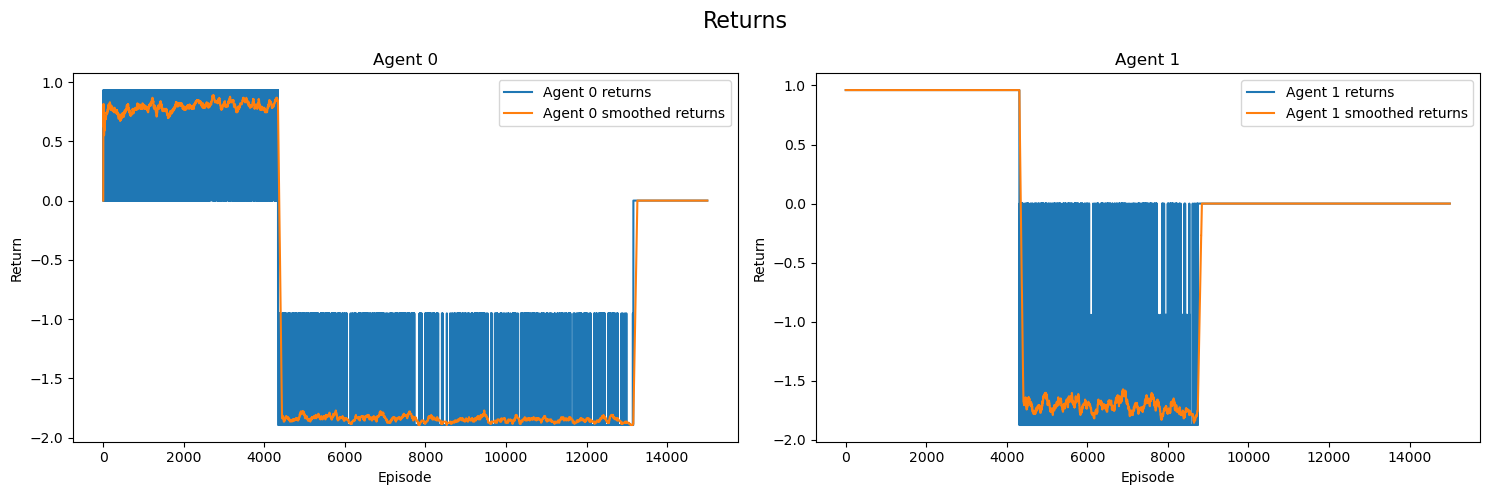

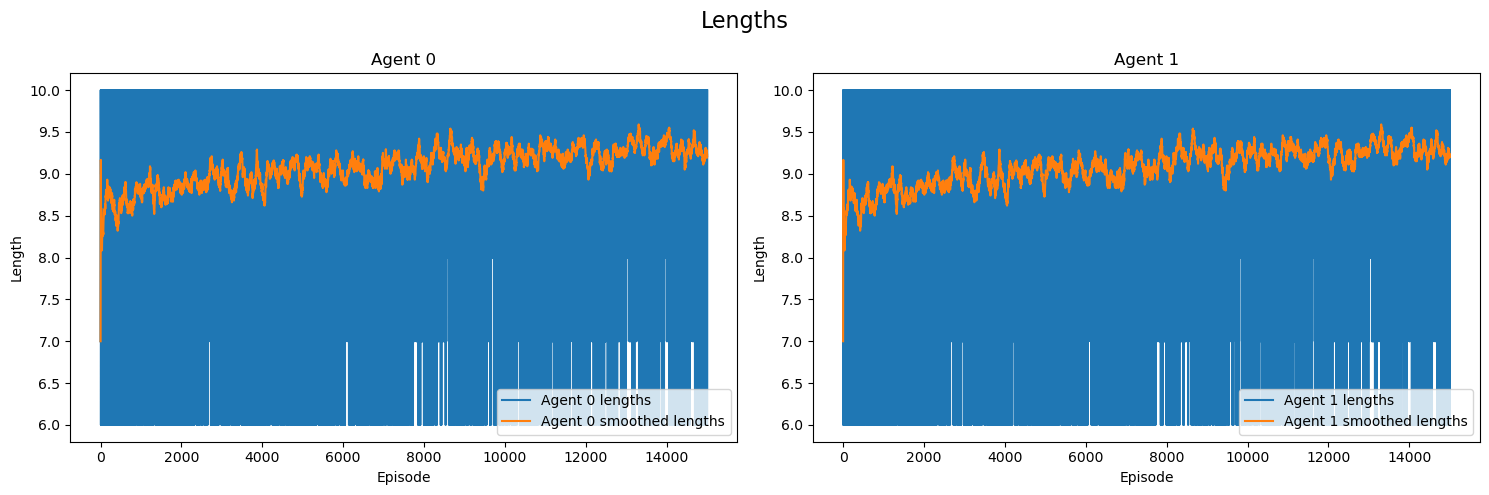

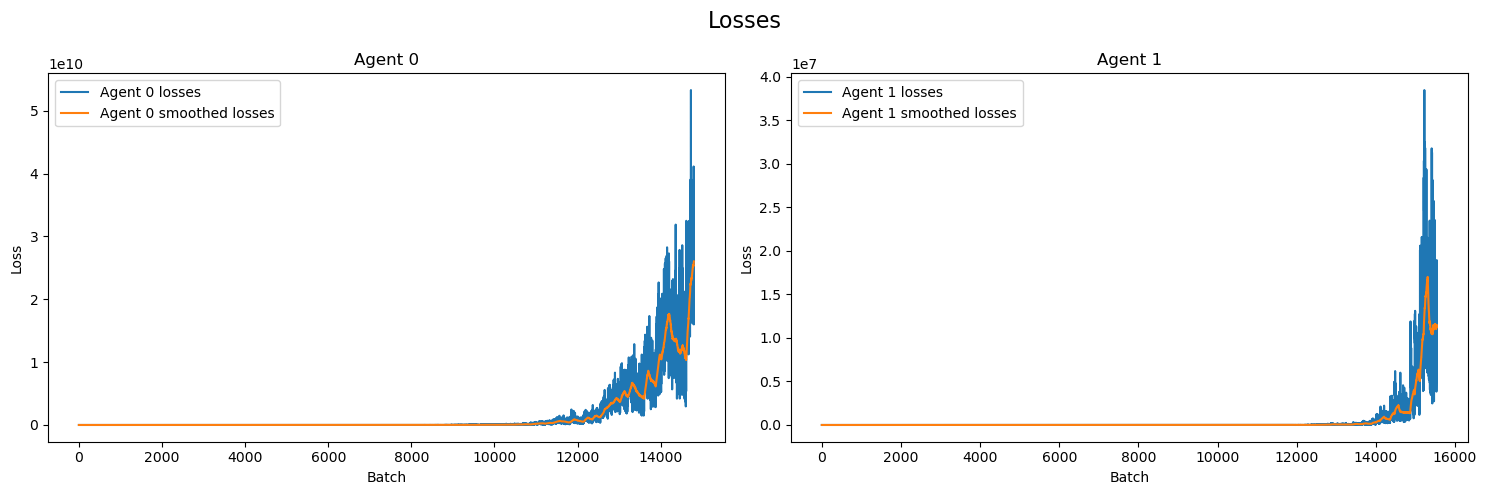

In [77]:
#read in the returns, lengths and losses from disk
returns_0 = np.load('agent_0/tictactoe/returns.npy', allow_pickle=True)
lengths_0 = np.load('agent_0/tictactoe/lengths.npy', allow_pickle=True)
losses_0 = np.load('agent_0/tictactoe/losses.npy', allow_pickle=True)

returns_1 = np.load('agent_1/tictactoe/returns.npy', allow_pickle=True)
lengths_1 = np.load('agent_1/tictactoe/lengths.npy', allow_pickle=True)
losses_1 = np.load('agent_1/tictactoe/losses.npy', allow_pickle=True)

window_size = 100

#smooth the returns, lengths and losses
smooth_returns_0 = rolling_average(returns_0, window_size=window_size)
smooth_lengths_0 = rolling_average(lengths_0, window_size=window_size)
smooth_losses_0 = rolling_average(losses_0, window_size=window_size)

smooth_returns_1 = rolling_average(returns_1, window_size=window_size)
smooth_lengths_1 = rolling_average(lengths_1, window_size=window_size)
smooth_losses_1 = rolling_average(losses_1, window_size=window_size)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Agent 0 Returns
axs[0].plot(returns_0, label='Agent 0 returns')
axs[0].plot(smooth_returns_0, label='Agent 0 smoothed returns')
axs[0].set_xlabel('Episode')
axs[0].set_ylabel('Return')
axs[0].set_title('Agent 0')
axs[0].legend()

# Agent 1 Returns
axs[1].plot(returns_1, label='Agent 1 returns')
axs[1].plot(smooth_returns_1, label='Agent 1 smoothed returns')
axs[1].set_xlabel('Episode')
axs[1].set_ylabel('Return')
axs[1].set_title('Agent 1')
axs[1].legend()

fig.suptitle('Returns', fontsize=16)

# Adjust subplot layout
plt.tight_layout()

# Show the plots
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Agent 0 Lengths
axs[0].plot(lengths_0, label='Agent 0 lengths')
axs[0].plot(smooth_lengths_0, label='Agent 0 smoothed lengths')
axs[0].set_xlabel('Episode')
axs[0].set_ylabel('Length')
axs[0].set_title('Agent 0')
axs[0].legend()

# Agent 1 Lengths
axs[1].plot(lengths_1, label='Agent 1 lengths')
axs[1].plot(smooth_lengths_1, label='Agent 1 smoothed lengths')
axs[1].set_xlabel('Episode')
axs[1].set_ylabel('Length')
axs[1].set_title('Agent 1')
axs[1].legend()

fig.suptitle('Lengths', fontsize=16)

# Adjust subplot layout
plt.tight_layout()

# Show the plots
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Agent 0 Losses
axs[0].plot(losses_0, label='Agent 0 losses')
axs[0].plot(smooth_losses_0, label='Agent 0 smoothed losses')
axs[0].set_xlabel('Batch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Agent 0')
axs[0].legend()

# Agent 1 Losses
axs[1].plot(losses_1, label='Agent 1 losses')
axs[1].plot(smooth_losses_1, label='Agent 1 smoothed losses')
axs[1].set_xlabel('Batch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Agent 1')
axs[1].legend()

#kake an overall title
fig.suptitle('Losses', fontsize=16)

# Adjust subplot layout
plt.tight_layout()

# Show the plots
plt.show()


In [15]:
#simlulate n games and store the results
def simulate_games(env, agent_0_model, agent_1_model, n=1000):
    results = {'agent_0': [], 'agent_1': []}

    dqn_0 = DQN.custom_load(agent_0_model)
    dqn_1 = DQN.custom_load(agent_1_model)

    for _ in tqdm.tqdm(range(n), desc="Playing Games"):

        #randomly choose which agent is which player
        players = ['agent_0', 'agent_1']
        np.random.shuffle(players) 
        player_0, player_1 = players
        
        #reset the environment
        env.reset()
        #play the game
        for agent in env.agent_iter():
            #assign the current agent to the player
            curr_agent = player_0 if agent == 'player_0' else player_1
            obs, reward, done, _, _ = env.last()
            if done:
                #if the game is done, store the result
                results[curr_agent].append(reward>0)
                results[player_1 if curr_agent == player_0 else player_0].append(reward<0)
                break
            else:
                #if the game is not done, get the action from the agent
                mask = obs['action_mask']
                curr_agent_model = dqn_0 if curr_agent == 'agent_0' else dqn_1
                action_probs = curr_agent_model(torch.tensor(obs['observation'].flatten(), dtype=torch.float))
                #set actionprobs at index of invalid actions to -inf
                action_probs[mask == 0] = -float('inf')   
                action = torch.argmax(action_probs).item()
                #advance the environment by one step
                env.step(action)
    return results


### Train Connect-4


In [59]:
env_name = 'connect_four'
env = envs[env_name]
gamma = 0.99

# we train for many time-steps;  as usual, you can decrease this during development / debugging.
# but make sure to restore it to 1_500_000 before submitting.
num_steps = 15000
num_saves = 5  # save models at 0%, 25%, 50%, 75% and 100% of training

replay_size = 20000
replay_prepopulate_steps = 1000

batch_size = 32
exploration = ExponentialSchedule(1.0, 0.01, 100_000)

num_layers = 3
hidden_dim = 32
target_update_freq = 500

# this should take about 90-120 minutes on a generic 4-core laptop
dqn_models, returns, lengths, losses = train_dqn_adversarial(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    gamma=gamma,
    num_layers=num_layers,
    hidden_dim=hidden_dim,
    target_update_freq=target_update_freq,
)


for agent in ['agent_0', 'agent_1']:

    assert len(dqn_models[agent]) == num_saves
    assert all(isinstance(value, DQN) for value in dqn_models[agent].values())

    # saving computed models to disk, so that we can load and visualize them later.
    checkpoint = {key: dqn.custom_dump() for key, dqn in dqn_models[agent].items()}
    torch.save(checkpoint, f'checkpoint_{env_name}_{agent}.pt')

    #save the returns, lengths and losses to disk
    # os.makedirs(f'{agent}/{env_name}', exist_ok=False)
    np.save(f'{agent}/{env_name}/returns.npy', np.array(returns[agent]), allow_pickle=True)
    np.save(f'{agent}/{env_name}/lengths.npy', np.array(lengths[agent]), allow_pickle=True)
    np.save(f'{agent}/{env_name}/losses.npy', np.array(losses[agent]), allow_pickle=True)

/home/elias/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/pettingzoo/utils/wrappers/base.py:72: UserWarning: The `action_spaces` dictionary is deprecated. Use the `action_space` function instead.
  warnings.warn(
Episode: 15000 | Steps: 1 | Return: -2.57 | Epsilon: 0.50: 100%|█| 15000/15000 [02:59<00:00, 83.67it
/tmp/ipykernel_911301/2251216193.py:47: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  np.save(f'{agent}/{env_name}/returns.npy', np.array(returns[agent]), allow_pickle=True)
/tmp/ipykernel_911301/2251216193.py:47: VisibleDeprecationWarning: Creating an ndarray from 

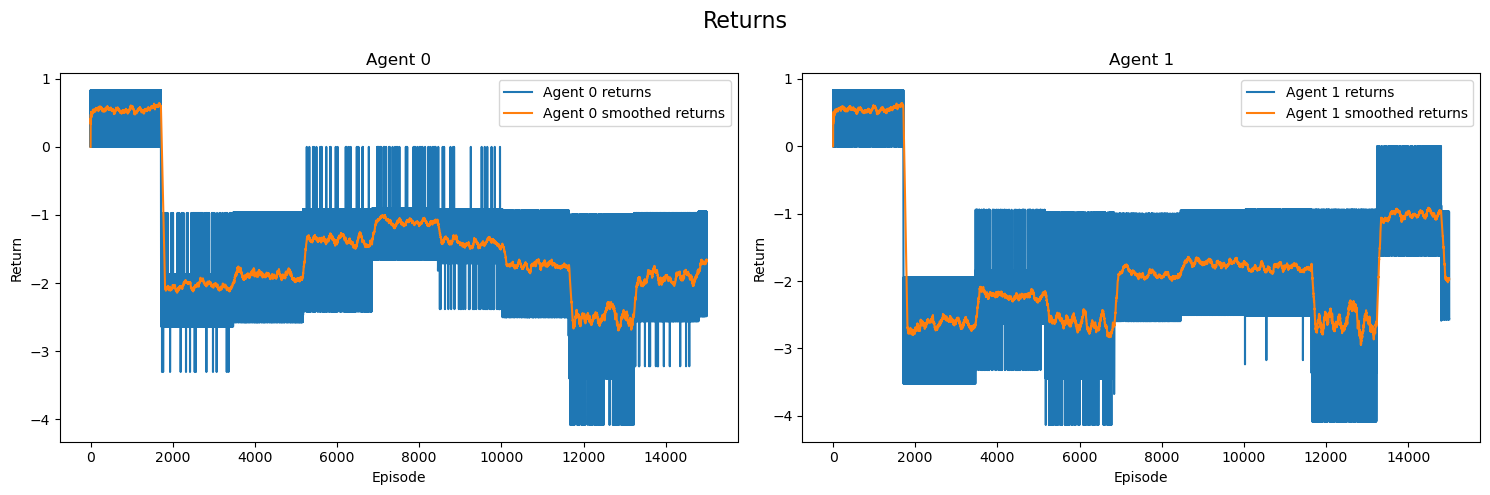

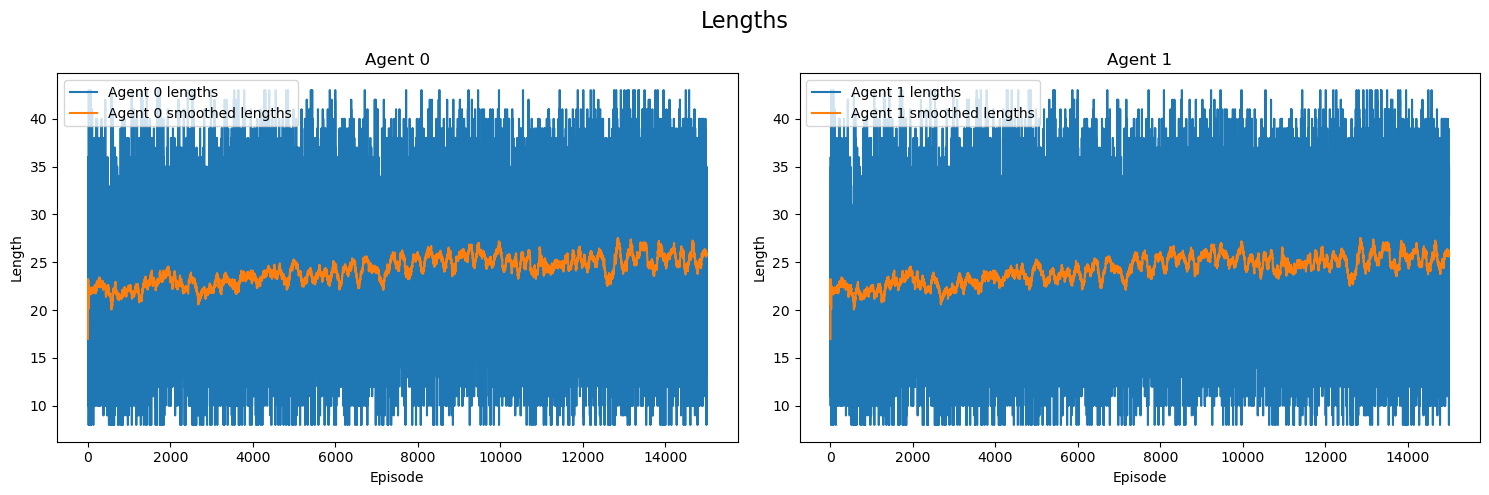

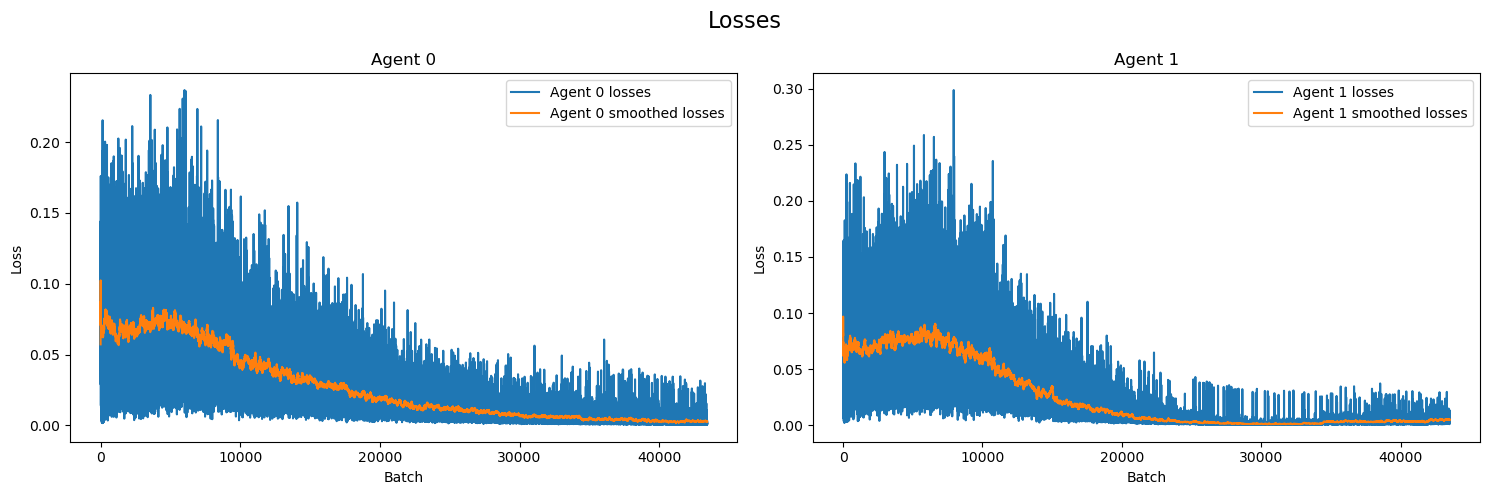

In [61]:
#read in the returns, lengths and losses from disk
returns_0 = np.load('agent_0/connect_four/returns.npy', allow_pickle=True)
lengths_0 = np.load('agent_0/connect_four/lengths.npy', allow_pickle=True)
losses_0 = np.load('agent_0/connect_four/losses.npy', allow_pickle=True)

returns_1 = np.load('agent_1/connect_four/returns.npy', allow_pickle=True)
lengths_1 = np.load('agent_1/connect_four/lengths.npy', allow_pickle=True)
losses_1 = np.load('agent_1/connect_four/losses.npy', allow_pickle=True)

window_size = 100

#smooth the returns, lengths and losses
smooth_returns_0 = rolling_average(returns_0, window_size=window_size)
smooth_lengths_0 = rolling_average(lengths_0, window_size=window_size)
smooth_losses_0 = rolling_average(losses_0, window_size=window_size)

smooth_returns_1 = rolling_average(returns_1, window_size=window_size)
smooth_lengths_1 = rolling_average(lengths_1, window_size=window_size)
smooth_losses_1 = rolling_average(losses_1, window_size=window_size)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Agent 0 Returns
axs[0].plot(returns_0, label='Agent 0 returns')
axs[0].plot(smooth_returns_0, label='Agent 0 smoothed returns')
axs[0].set_xlabel('Episode')
axs[0].set_ylabel('Return')
axs[0].set_title('Agent 0')
axs[0].legend()

# Agent 1 Returns
axs[1].plot(returns_1, label='Agent 1 returns')
axs[1].plot(smooth_returns_1, label='Agent 1 smoothed returns')
axs[1].set_xlabel('Episode')
axs[1].set_ylabel('Return')
axs[1].set_title('Agent 1')
axs[1].legend()

fig.suptitle('Returns', fontsize=16)

# Adjust subplot layout
plt.tight_layout()

# Show the plots
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Agent 0 Lengths
axs[0].plot(lengths_0, label='Agent 0 lengths')
axs[0].plot(smooth_lengths_0, label='Agent 0 smoothed lengths')
axs[0].set_xlabel('Episode')
axs[0].set_ylabel('Length')
axs[0].set_title('Agent 0')
axs[0].legend()

# Agent 1 Lengths
axs[1].plot(lengths_1, label='Agent 1 lengths')
axs[1].plot(smooth_lengths_1, label='Agent 1 smoothed lengths')
axs[1].set_xlabel('Episode')
axs[1].set_ylabel('Length')
axs[1].set_title('Agent 1')
axs[1].legend()

fig.suptitle('Lengths', fontsize=16)

# Adjust subplot layout
plt.tight_layout()

# Show the plots
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Agent 0 Losses
axs[0].plot(losses_0, label='Agent 0 losses')
axs[0].plot(smooth_losses_0, label='Agent 0 smoothed losses')
axs[0].set_xlabel('Batch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Agent 0')
axs[0].legend()

# Agent 1 Losses
axs[1].plot(losses_1, label='Agent 1 losses')
axs[1].plot(smooth_losses_1, label='Agent 1 smoothed losses')
axs[1].set_xlabel('Batch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Agent 1')
axs[1].legend()

#kake an overall title
fig.suptitle('Losses', fontsize=16)

# Adjust subplot layout
plt.tight_layout()

# Show the plots
plt.show()


### Online Simulation Loop

In [10]:
def interact_with_online_learning(env, agent_0_dict, agent_0_online, agent_1_dict, agent_1_online, num_episodes, batch_size, gamma, exploration, replay_size, target_update_freq, coop):
    """
    Interact in the environment with one agent learning online.

    Args:
        - env: The openai Gym environment
        - dqn_model: DQN model of the agent that will learn online
        - opponent_model: Model of the opponent agent
        - num_episodes: Number of episodes for interaction
        - batch_size: Batch size for online learning
        - gamma: Discount factor for DQN updates
        - exploration: Exploration strategy (e.g., epsilon-greedy)

    Returns:
        - interaction_results: Results of the interaction
    """
    agent_0 = DQN.custom_load(agent_0_dict)
    agent_1 = DQN.custom_load(agent_1_dict)
    interaction_results = {'agent_0': [], 'agent_1': []}
    is_online = {'agent_0': agent_0_online, 'agent_1': agent_1_online}
    observation_space = np.prod(env.observation_spaces[env.possible_agents[0]]['observation'].shape)


    if agent_0_online:
        memory_0 = ReplayMemory(replay_size, observation_space)
        optimizer_0 = optim.Adam(agent_0.parameters())
        agent_0_target = copy.deepcopy(agent_0)

    if agent_1_online:
        memory_1 = ReplayMemory(replay_size, observation_space)
        optimizer_1 = optim.Adam(agent_1.parameters())
        agent_1_target = copy.deepcopy(agent_1)

    step_count = 0

    for i_episode in tqdm.trange(num_episodes, ncols=100):
        env.reset()
        players = ['agent_0', 'agent_1']
        np.random.shuffle(players)
        player_0, player_1 = players

        for agent in env.agent_iter():
            curr_agent = player_0 if agent == 'player_0' else player_1
            obs, reward, done, _, _ = env.last()

            if done:
                if coop:
                    interaction_results[curr_agent].append(reward)
                    interaction_results[player_1 if curr_agent == player_0 else player_0].append(reward)
                else:
                    interaction_results[curr_agent].append(reward)
                    interaction_results[player_1 if curr_agent == player_0 else player_0].append(-reward)
                break
            
            mask = obs['action_mask']
            # Action selection
            if is_online[curr_agent]:
                eps = exploration.value(i_episode)
                if np.random.rand() < eps:
                    action = env.action_spaces[agent].sample(mask)
                else:
                    curr_agent_model = agent_0 if curr_agent == 'agent_0' else agent_1
                    action_probs = curr_agent_model(torch.tensor(obs['observation'].flatten(), dtype=torch.float))
                    #set actionprobs at index of invalid actions to -inf
                    action_probs[mask == 0] = -float('inf')
                    action = torch.argmax(action_probs).item()
            else:
                curr_agent_model = agent_0 if curr_agent == 'agent_0' else agent_1
                # Opponent's action
                action_probs = curr_agent_model(torch.tensor(obs['observation'].flatten(), dtype=torch.float))
                #set actionprobs at index of invalid actions to -inf
                action_probs[mask == 0] = -float('inf')
                action = torch.argmax(action_probs).item()

            # Advance the environment
            env.step(action)
            next_obs, reward, done, _ , _= env.last()

            # Online learning for the agent
            if is_online[curr_agent]:
                if curr_agent == 'agent_0':
                    memory_0.add(obs['observation'], action, reward, next_obs['observation'], done)
                    batch = memory_0.sample(batch_size)
                    loss = train_dqn_batch(optimizer_0, batch, agent_0, agent_0_target, gamma)
                else:
                    memory_1.add(obs['observation'], action, reward, next_obs['observation'], done)
                    batch = memory_1.sample(batch_size)
                    loss = train_dqn_batch(optimizer_1, batch, agent_1, agent_1_target, gamma)

            step_count += 1

            if step_count % target_update_freq == 0:
                if agent_0_online:
                    agent_0_target.load_state_dict(agent_0.state_dict())
                if agent_1_online:
                    agent_1_target.load_state_dict(agent_1.state_dict())

    return interaction_results


## Simulations

### Tic Tac Toe

In [80]:
env = envs['tictactoe']
env_name = 'tictactoe'

agent_0_models= torch.load('checkpoint_tictactoe_agent_0.pt')
agent_1_models= torch.load('checkpoint_tictactoe_agent_1.pt')

no_no = {'agent_0': [], 'agent_1': []}
yes_no = {'agent_0': [], 'agent_1': []}
yes_yes = {'agent_0': [], 'agent_1': []}

for i in range(5):

    #simluate interactions between 2 non-learning agents
    inter_no_no = interact_with_online_learning(
        env, 
        agent_0_dict=agent_0_models['100_0'], 
        agent_0_online=False, 
        agent_1_dict=agent_1_models['100_0'],
        agent_1_online=False,
        num_episodes=5000,
        batch_size=32,
        gamma=0.99,
        exploration=ExponentialSchedule(1.0, 0.01, 100_000),
        replay_size=200000,
        target_update_freq=500,
        coop=False
    )

    no_no['agent_0'].append(inter_no_no['agent_0'])
    no_no['agent_1'].append(inter_no_no['agent_1'])

    #simluate interactions between 2 non-learning agents
    inter_yes_no = interact_with_online_learning(
        env, 
        agent_0_dict=agent_0_models['100_0'], 
        agent_0_online=True, 
        agent_1_dict=agent_1_models['100_0'],
        agent_1_online=False,
        num_episodes=5000,
        batch_size=32,
        gamma=0.99,
        exploration=ExponentialSchedule(1.0, 0.01, 100_000),
        replay_size=200000,
        target_update_freq=500,
        coop=False
    )

    yes_no['agent_0'].append(inter_yes_no['agent_0'])
    yes_no['agent_1'].append(inter_yes_no['agent_1'])


    #simluate interactions between 2 non-learning agents
    inter_yes_yes = interact_with_online_learning(
        env, 
        agent_0_dict=agent_0_models['100_0'], 
        agent_0_online=True, 
        agent_1_dict=agent_1_models['100_0'],
        agent_1_online=True,
        num_episodes=5000,
        batch_size=32,
        gamma=0.99,
        exploration=ExponentialSchedule(1.0, 0.01, 100_000),
        replay_size=200000,
        target_update_freq=500,
        coop=False
    )

    yes_yes['agent_0'].append(inter_yes_yes['agent_0'])
    yes_yes['agent_1'].append(inter_yes_yes['agent_1'])


100%|██████████████████████████████████████████████████████████| 5000/5000 [00:39<00:00, 126.10it/s]


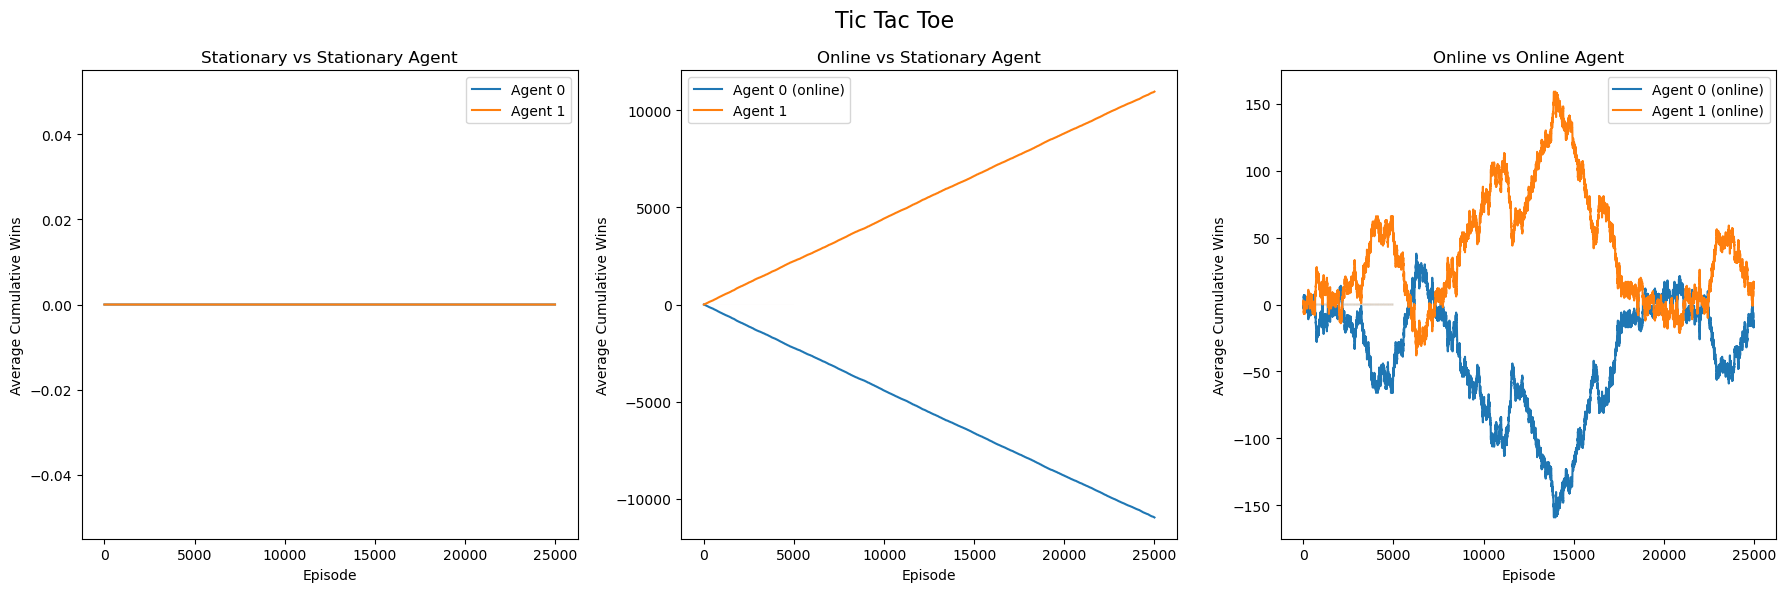

In [81]:
agent_0_cumsums = {'no_no': np.cumsum(np.array(no_no['agent_0'])), 'yes_no': np.cumsum(np.array(yes_no['agent_0'])), 'yes_yes': np.cumsum(np.array(yes_yes['agent_0']))}
agent_1_cumsums = {'no_no': np.cumsum(np.array(no_no['agent_1'])), 'yes_no': np.cumsum(np.array(yes_no['agent_1'])), 'yes_yes': np.cumsum(np.array(yes_yes['agent_1']))}

#get the mean and confidence bands 1.96 * standard error
agent_0_means = {'no_no': np.mean(np.array(no_no['agent_0']), axis=0), 'yes_no': np.mean(np.array(yes_no['agent_0']), axis=0), 'yes_yes': np.mean(np.array(yes_yes['agent_0']), axis=0)}
agent_0_conf = {'no_no': 1.96 * np.std(np.array(no_no['agent_0']), axis=0) / np.sqrt(5), 'yes_no': 1.96 * np.std(np.array(yes_no['agent_0']), axis=0) / np.sqrt(5), 'yes_yes': 1.96 * np.std(np.array(yes_yes['agent_0']), axis=0) / np.sqrt(5)}

agent_1_means = {'no_no': np.mean(np.array(no_no['agent_1']), axis=0), 'yes_no': np.mean(np.array(yes_no['agent_1']), axis=0), 'yes_yes': np.mean(np.array(yes_yes['agent_1']), axis=0)}
agent_1_conf = {'no_no': 1.96 * np.std(np.array(no_no['agent_1']), axis=0) / np.sqrt(5), 'yes_no': 1.96 * np.std(np.array(yes_no['agent_1']), axis=0) / np.sqrt(5), 'yes_yes': 1.96 * np.std(np.array(yes_yes['agent_1']), axis=0) / np.sqrt(5)}

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns for three plots side by side

# Plot 1: Cumulative Wins for 'no_no'
axs[0].plot(agent_0_cumsums['no_no'], label='Agent 0')
axs[0].plot(agent_1_cumsums['no_no'], label='Agent 1')
axs[0].fill_between(np.arange(len(agent_0_means['no_no'])), agent_0_means['no_no'] - agent_0_conf['no_no'], agent_0_means['no_no'] + agent_0_conf['no_no'], alpha=0.2)
axs[0].fill_between(np.arange(len(agent_1_means['no_no'])), agent_1_means['no_no'] - agent_1_conf['no_no'], agent_1_means['no_no'] + agent_1_conf['no_no'], alpha=0.2)
axs[0].set_xlabel('Episode')
axs[0].set_ylabel('Average Cumulative Wins')
axs[0].set_title('Stationary vs Stationary Agent')
axs[0].legend()

# Plot 2: Cumulative Wins for 'yes_no'
axs[1].plot(agent_0_cumsums['yes_no'], label='Agent 0 (online)')
axs[1].plot(agent_1_cumsums['yes_no'], label='Agent 1')
axs[1].fill_between(np.arange(len(agent_0_means['yes_no'])), agent_0_means['yes_no'] - agent_0_conf['yes_no'], agent_0_means['yes_no'] + agent_0_conf['yes_no'], alpha=0.2)
axs[1].fill_between(np.arange(len(agent_1_means['yes_no'])), agent_1_means['yes_no'] - agent_1_conf['yes_no'], agent_1_means['yes_no'] + agent_1_conf['yes_no'], alpha=0.2)
axs[1].set_xlabel('Episode')
axs[1].set_ylabel('Average Cumulative Wins')
axs[1].set_title('Online vs Stationary Agent')
axs[1].legend()

# Plot 3: Cumulative Wins for 'yes_yes'
axs[2].plot(agent_0_cumsums['yes_yes'], label='Agent 0 (online)')
axs[2].plot(agent_1_cumsums['yes_yes'], label='Agent 1 (online)')
axs[2].fill_between(np.arange(len(agent_0_means['yes_yes'])), agent_0_means['yes_yes'] - agent_0_conf['yes_yes'], agent_0_means['yes_yes'] + agent_0_conf['yes_yes'], alpha=0.2)
axs[2].fill_between(np.arange(len(agent_1_means['yes_yes'])), agent_1_means['yes_yes'] - agent_1_conf['yes_yes'], agent_1_means['yes_yes'] + agent_1_conf['yes_yes'], alpha=0.2)
axs[2].set_xlabel('Episode')
axs[2].set_ylabel('Average Cumulative Wins')
axs[2].set_title('Online vs Online Agent')
axs[2].legend()

fig.suptitle('Tic Tac Toe', fontsize=16)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()


### Connect Four

In [71]:
env = connect_four_v3.env(render_mode='rgb_array')
env_name = 'connect_four'


agent_0_models= torch.load('checkpoint_connect_four_agent_0.pt')
agent_1_models= torch.load('checkpoint_connect_four_agent_0.pt')

no_no = {'agent_0': [], 'agent_1': []}
yes_no = {'agent_0': [], 'agent_1': []}
yes_yes = {'agent_0': [], 'agent_1': []}

for i in range(5):

    #simluate interactions between 2 non-learning agents
    inter_no_no = interact_with_online_learning(
        env, 
        agent_0_dict=agent_0_models['100_0'], 
        agent_0_online=False, 
        agent_1_dict=agent_1_models['100_0'],
        agent_1_online=False,
        num_episodes=5000,
        batch_size=32,
        gamma=0.99,
        exploration=ExponentialSchedule(1.0, 0.01, 100_000),
        replay_size=200000,
        target_update_freq=500,
        coop=False
    )

    no_no['agent_0'].append(inter_no_no['agent_0'])
    no_no['agent_1'].append(inter_no_no['agent_1'])

    #simluate interactions between 2 non-learning agents
    inter_yes_no = interact_with_online_learning(
        env, 
        agent_0_dict=agent_0_models['100_0'], 
        agent_0_online=True, 
        agent_1_dict=agent_1_models['100_0'],
        agent_1_online=False,
        num_episodes=5000,
        batch_size=32,
        gamma=0.99,
        exploration=ExponentialSchedule(1.0, 0.01, 100_000),
        replay_size=200000,
        target_update_freq=500,
        coop=False
    )

    yes_no['agent_0'].append(inter_yes_no['agent_0'])
    yes_no['agent_1'].append(inter_yes_no['agent_1'])


    #simluate interactions between 2 non-learning agents
    inter_yes_yes = interact_with_online_learning(
        env, 
        agent_0_dict=agent_0_models['100_0'], 
        agent_0_online=True, 
        agent_1_dict=agent_1_models['100_0'],
        agent_1_online=True,
        num_episodes=5000,
        batch_size=32,
        gamma=0.99,
        exploration=ExponentialSchedule(1.0, 0.01, 100_000),
        replay_size=200000,
        target_update_freq=500,
        coop=False
    )

    yes_yes['agent_0'].append(inter_yes_yes['agent_0'])
    yes_yes['agent_1'].append(inter_yes_yes['agent_1'])


/home/elias/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/pettingzoo/utils/wrappers/base.py:58: UserWarning: The `observation_spaces` dictionary is deprecated. Use the `observation_space` function instead.
  warnings.warn(
  0%|                                                                      | 0/5000 [00:00<?, ?it/s]/home/elias/anaconda3/envs/pytorch-env/lib/python3.11/site-packages/pettingzoo/utils/wrappers/base.py:72: UserWarning: The `action_spaces` dictionary is deprecated. Use the `action_space` function instead.
  warnings.warn(
100%|███████████████████████████████████████████████████████████| 5000/5000 [01:54<00:00, 43.68it/s]


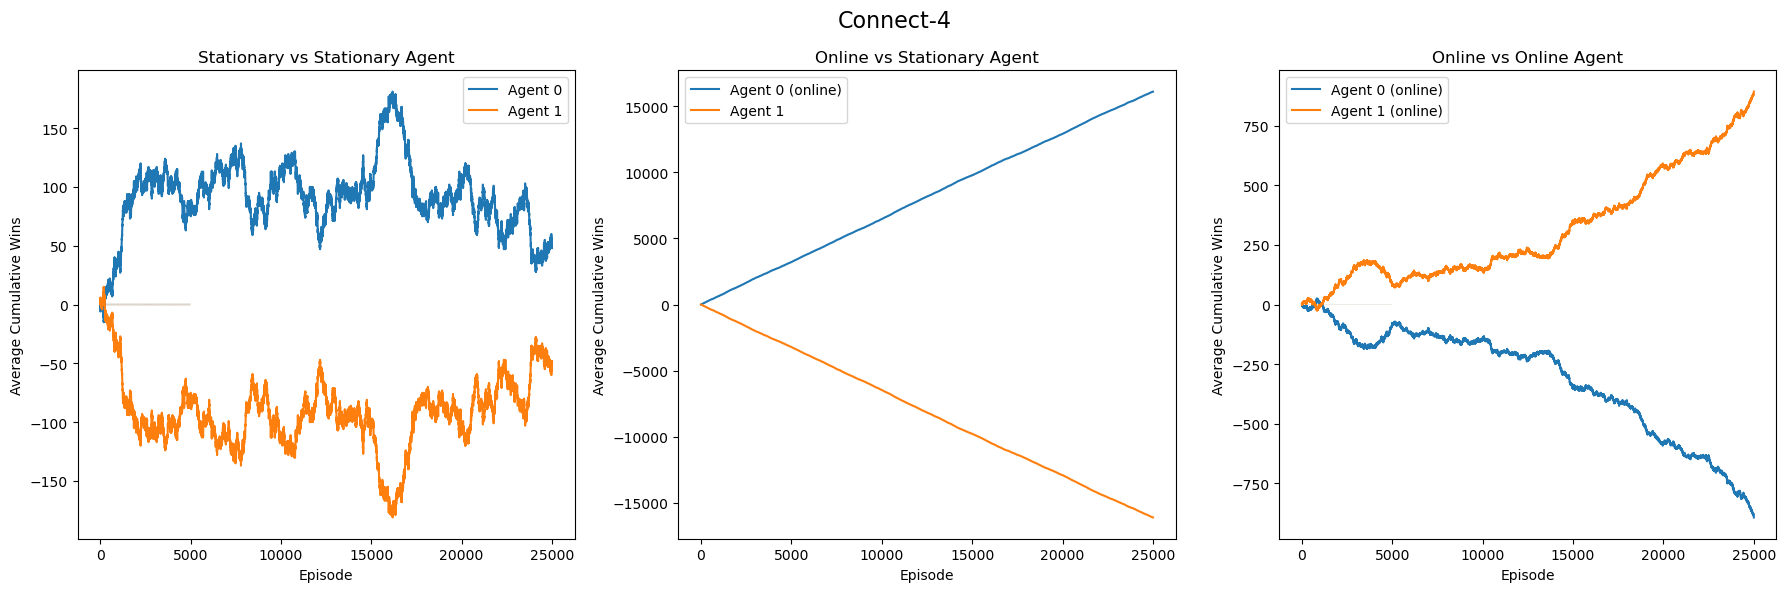

In [72]:
agent_0_cumsums = {'no_no': np.cumsum(np.array(no_no['agent_0'])), 'yes_no': np.cumsum(np.array(yes_no['agent_0'])), 'yes_yes': np.cumsum(np.array(yes_yes['agent_0']))}
agent_1_cumsums = {'no_no': np.cumsum(np.array(no_no['agent_1'])), 'yes_no': np.cumsum(np.array(yes_no['agent_1'])), 'yes_yes': np.cumsum(np.array(yes_yes['agent_1']))}

#get the mean and confidence bands 1.96 * standard error
agent_0_means = {'no_no': np.mean(np.array(no_no['agent_0']), axis=0), 'yes_no': np.mean(np.array(yes_no['agent_0']), axis=0), 'yes_yes': np.mean(np.array(yes_yes['agent_0']), axis=0)}
agent_0_conf = {'no_no': 1.96 * np.std(np.array(no_no['agent_0']), axis=0) / np.sqrt(5), 'yes_no': 1.96 * np.std(np.array(yes_no['agent_0']), axis=0) / np.sqrt(5), 'yes_yes': 1.96 * np.std(np.array(yes_yes['agent_0']), axis=0) / np.sqrt(5)}

agent_1_means = {'no_no': np.mean(np.array(no_no['agent_1']), axis=0), 'yes_no': np.mean(np.array(yes_no['agent_1']), axis=0), 'yes_yes': np.mean(np.array(yes_yes['agent_1']), axis=0)}
agent_1_conf = {'no_no': 1.96 * np.std(np.array(no_no['agent_1']), axis=0) / np.sqrt(5), 'yes_no': 1.96 * np.std(np.array(yes_no['agent_1']), axis=0) / np.sqrt(5), 'yes_yes': 1.96 * np.std(np.array(yes_yes['agent_1']), axis=0) / np.sqrt(5)}

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns for three plots side by side

# Plot 1: Cumulative Wins for 'no_no'
axs[0].plot(agent_0_cumsums['no_no'], label='Agent 0')
axs[0].plot(agent_1_cumsums['no_no'], label='Agent 1')
axs[0].fill_between(np.arange(len(agent_0_means['no_no'])), agent_0_means['no_no'] - agent_0_conf['no_no'], agent_0_means['no_no'] + agent_0_conf['no_no'], alpha=0.2)
axs[0].fill_between(np.arange(len(agent_1_means['no_no'])), agent_1_means['no_no'] - agent_1_conf['no_no'], agent_1_means['no_no'] + agent_1_conf['no_no'], alpha=0.2)
axs[0].set_xlabel('Episode')
axs[0].set_ylabel('Average Cumulative Wins')
axs[0].set_title('Stationary vs Stationary Agent')
axs[0].legend()

# Plot 2: Cumulative Wins for 'yes_no'
axs[1].plot(agent_0_cumsums['yes_no'], label='Agent 0 (online)')
axs[1].plot(agent_1_cumsums['yes_no'], label='Agent 1')
axs[1].fill_between(np.arange(len(agent_0_means['yes_no'])), agent_0_means['yes_no'] - agent_0_conf['yes_no'], agent_0_means['yes_no'] + agent_0_conf['yes_no'], alpha=0.2)
axs[1].fill_between(np.arange(len(agent_1_means['yes_no'])), agent_1_means['yes_no'] - agent_1_conf['yes_no'], agent_1_means['yes_no'] + agent_1_conf['yes_no'], alpha=0.2)
axs[1].set_xlabel('Episode')
axs[1].set_ylabel('Average Cumulative Wins')
axs[1].set_title('Online vs Stationary Agent')
axs[1].legend()

# Plot 3: Cumulative Wins for 'yes_yes'
axs[2].plot(agent_0_cumsums['yes_yes'], label='Agent 0 (online)')
axs[2].plot(agent_1_cumsums['yes_yes'], label='Agent 1 (online)')
axs[2].fill_between(np.arange(len(agent_0_means['yes_yes'])), agent_0_means['yes_yes'] - agent_0_conf['yes_yes'], agent_0_means['yes_yes'] + agent_0_conf['yes_yes'], alpha=0.2)
axs[2].fill_between(np.arange(len(agent_1_means['yes_yes'])), agent_1_means['yes_yes'] - agent_1_conf['yes_yes'], agent_1_means['yes_yes'] + agent_1_conf['yes_yes'], alpha=0.2)
axs[2].set_xlabel('Episode')
axs[2].set_ylabel('Average Cumulative Wins')
axs[2].set_title('Online vs Online Agent')
axs[2].legend()

fig.suptitle('Connect-4', fontsize=16)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()


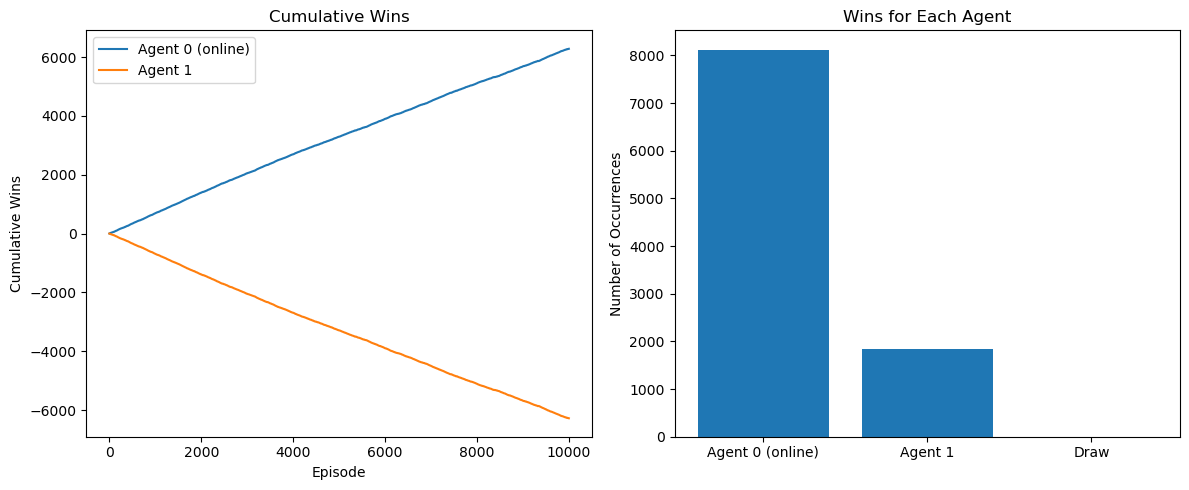

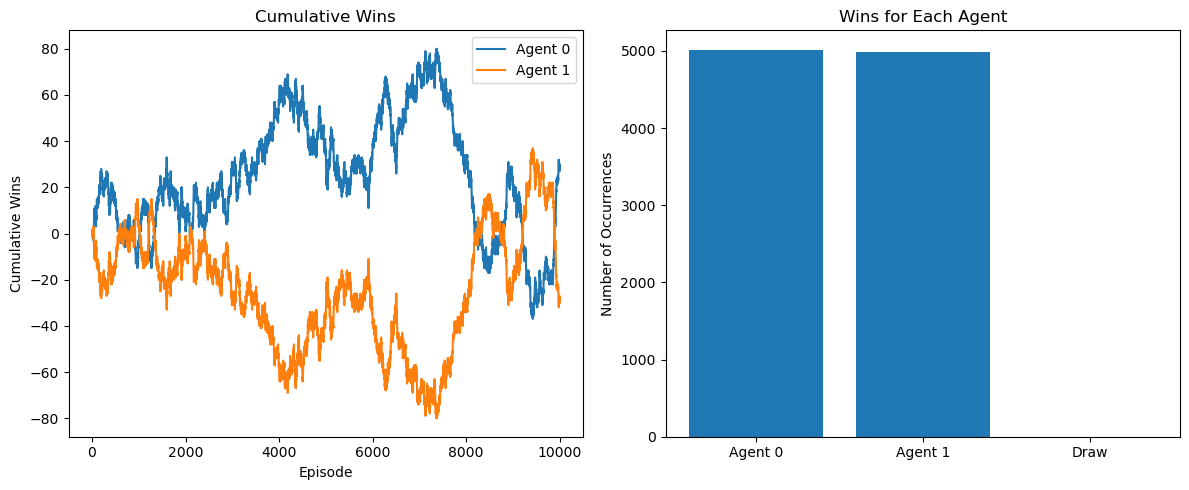

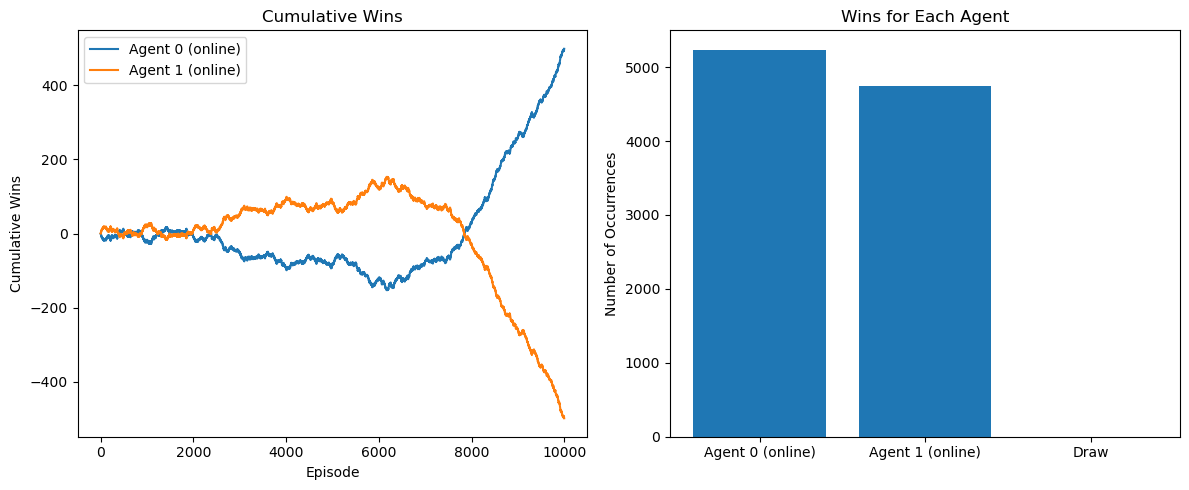

In [63]:
# Data
agent_0_wins = np.sum(np.array(inter_yes_no['agent_0']) > 0)
agent_1_wins = np.sum(np.array(inter_yes_no['agent_1']) > 0)
draws = np.sum(np.array(inter_no_no['agent_0']) == 0)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Bar chart
axs[1].bar(['Agent 0 (online)', 'Agent 1', 'Draw'], [agent_0_wins, agent_1_wins, draws])
axs[1].set_ylabel('Number of Occurrences')
axs[1].set_title('Wins for Each Agent')

# Plot 2: Line chart
axs[0].plot(np.cumsum(inter_yes_no['agent_0']), label='Agent 0 (online)')
axs[0].plot(np.cumsum(inter_yes_no['agent_1']), label='Agent 1')
axs[0].set_xlabel('Episode')
axs[0].set_ylabel('Cumulative Wins')
axs[0].set_title('Cumulative Wins')
axs[0].legend()

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

# Data
agent_0_wins = np.sum(np.array(inter_no_no['agent_0']) > 0)
agent_1_wins = np.sum(np.array(inter_no_no['agent_1']) > 0)
draws = np.sum(np.array(inter_no_no['agent_0']) == 0)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Bar chart
axs[1].bar(['Agent 0', 'Agent 1', 'Draw'], [agent_0_wins, agent_1_wins, draws])
axs[1].set_ylabel('Number of Occurrences')
axs[1].set_title('Wins for Each Agent')

# Plot 2: Line chart
axs[0].plot(np.cumsum(inter_no_no['agent_0']), label='Agent 0')
axs[0].plot(np.cumsum(inter_no_no['agent_1']), label='Agent 1')
axs[0].set_xlabel('Episode')
axs[0].set_ylabel('Cumulative Wins')
axs[0].set_title('Cumulative Wins')
axs[0].legend()

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()

# Data
agent_0_wins = np.sum(np.array(inter_yes_yes['agent_0']) > 0)
agent_1_wins = np.sum(np.array(inter_yes_yes['agent_1']) > 0)
draws = np.sum(np.array(inter_no_no['agent_0']) == 0)

# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 5))

# Plot 1: Bar chart
axs[1].bar(['Agent 0 (online)', 'Agent 1 (online)', 'Draw'], [agent_0_wins, agent_1_wins, draws])
axs[1].set_ylabel('Number of Occurrences')
axs[1].set_title('Wins for Each Agent')

# Plot 2: Line chart
axs[0].plot(np.cumsum(inter_yes_yes['agent_0']), label='Agent 0 (online)')
axs[0].plot(np.cumsum(inter_yes_yes['agent_1']), label='Agent 1 (online)')
axs[0].set_xlabel('Episode')
axs[0].set_ylabel('Cumulative Wins')
axs[0].set_title('Cumulative Wins')
axs[0].legend()

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()




### Leduc Hold'em Training

In [82]:
env = leduc_holdem_v4.env(render_mode="rgb_array")
env_name = 'leduc_holdem'
gamma = 0.99

# we train for many time-steps;  as usual, you can decrease this during development / debugging.
# but make sure to restore it to 1_500_000 before submitting.
num_steps = 30000
num_saves = 5  # save models at 0%, 25%, 50%, 75% and 100% of training

replay_size = 20000
replay_prepopulate_steps = 1000

batch_size = 32
exploration = ExponentialSchedule(1.0, 0.01, 100_000)

num_layers = 3
hidden_dim = 32
target_update_freq = 100

# this should take about 90-120 minutes on a generic 4-core laptop
dqn_models, returns, lengths, losses = train_dqn_adversarial(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    gamma=gamma,
    num_layers=num_layers,
    hidden_dim=hidden_dim,
    target_update_freq=target_update_freq,
)

for agent in ['agent_0', 'agent_1']:

    assert len(dqn_models[agent]) == num_saves
    assert all(isinstance(value, DQN) for value in dqn_models[agent].values())

    # saving computed models to disk, so that we can load and visualize them later.
    checkpoint = {key: dqn.custom_dump() for key, dqn in dqn_models[agent].items()}
    torch.save(checkpoint, f'checkpoint_{env_name}_{agent}.pt')

    #save the returns, lengths and losses to disk
    # os.makedirs(f'{agent}/{env_name}', exist_ok=False)
    np.save(f'{agent}/{env_name}/returns.npy', np.array(returns[agent]), allow_pickle=True)
    np.save(f'{agent}/{env_name}/lengths.npy', np.array(lengths[agent]), allow_pickle=True)
    np.save(f'{agent}/{env_name}/losses.npy', np.array(losses[agent]), allow_pickle=True)

Episode: 30000 | Steps: 1 | Return:  8.68 | Epsilon: 0.25: 100%|█| 30000/30000 [01:20<00:00, 372.78i


FileExistsError: [Errno 17] File exists: 'agent_0/leduc_holdem'

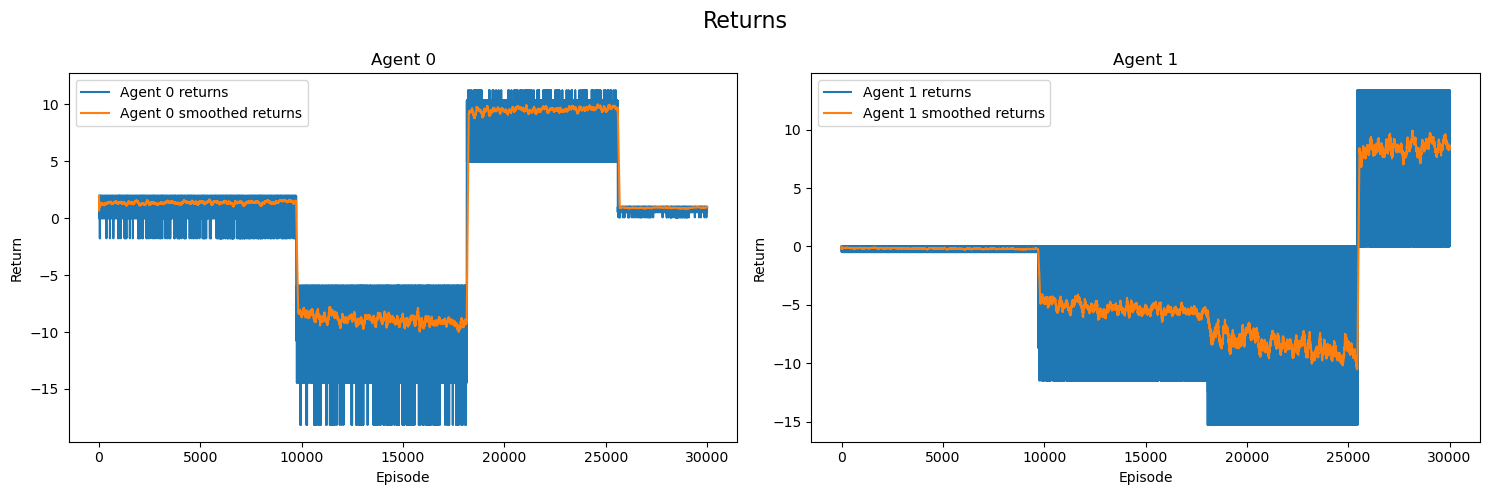

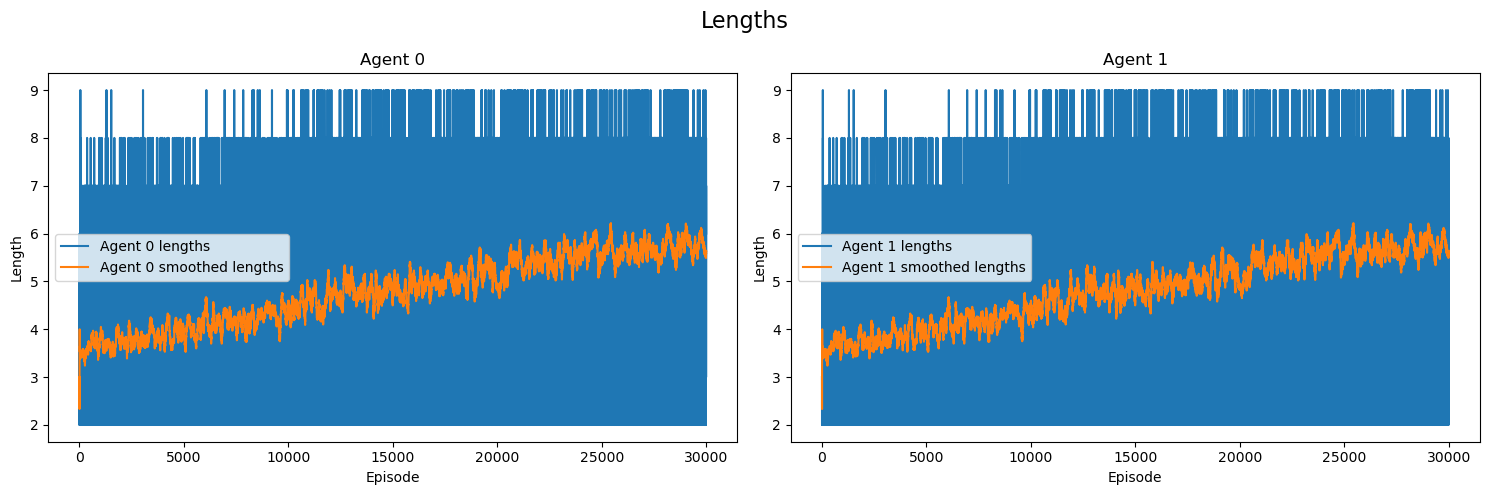

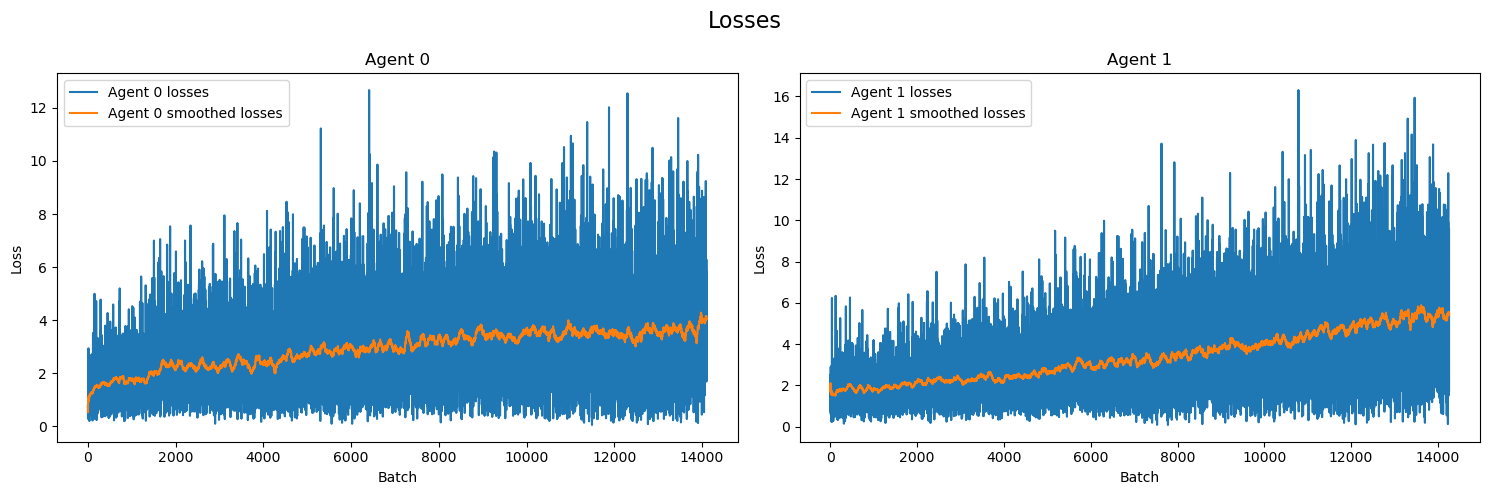

In [84]:
#read in the returns, lengths and losses from disk
returns_0 = np.load('agent_0/leduc_holdem/returns.npy', allow_pickle=True)
lengths_0 = np.load('agent_0/leduc_holdem/lengths.npy', allow_pickle=True)
losses_0 = np.load('agent_0/leduc_holdem/losses.npy', allow_pickle=True)

returns_1 = np.load('agent_1/leduc_holdem/returns.npy', allow_pickle=True)
lengths_1 = np.load('agent_1/leduc_holdem/lengths.npy', allow_pickle=True)
losses_1 = np.load('agent_1/leduc_holdem/losses.npy', allow_pickle=True)

window_size = 100

#smooth the returns, lengths and losses
smooth_returns_0 = rolling_average(returns_0, window_size=window_size)
smooth_lengths_0 = rolling_average(lengths_0, window_size=window_size)
smooth_losses_0 = rolling_average(losses_0, window_size=window_size)

smooth_returns_1 = rolling_average(returns_1, window_size=window_size)
smooth_lengths_1 = rolling_average(lengths_1, window_size=window_size)
smooth_losses_1 = rolling_average(losses_1, window_size=window_size)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Agent 0 Returns
axs[0].plot(returns_0, label='Agent 0 returns')
axs[0].plot(smooth_returns_0, label='Agent 0 smoothed returns')
axs[0].set_xlabel('Episode')
axs[0].set_ylabel('Return')
axs[0].set_title('Agent 0')
axs[0].legend()

# Agent 1 Returns
axs[1].plot(returns_1, label='Agent 1 returns')
axs[1].plot(smooth_returns_1, label='Agent 1 smoothed returns')
axs[1].set_xlabel('Episode')
axs[1].set_ylabel('Return')
axs[1].set_title('Agent 1')
axs[1].legend()

fig.suptitle('Returns', fontsize=16)

# Adjust subplot layout
plt.tight_layout()

# Show the plots
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Agent 0 Lengths
axs[0].plot(lengths_0, label='Agent 0 lengths')
axs[0].plot(smooth_lengths_0, label='Agent 0 smoothed lengths')
axs[0].set_xlabel('Episode')
axs[0].set_ylabel('Length')
axs[0].set_title('Agent 0')
axs[0].legend()

# Agent 1 Lengths
axs[1].plot(lengths_1, label='Agent 1 lengths')
axs[1].plot(smooth_lengths_1, label='Agent 1 smoothed lengths')
axs[1].set_xlabel('Episode')
axs[1].set_ylabel('Length')
axs[1].set_title('Agent 1')
axs[1].legend()

fig.suptitle('Lengths', fontsize=16)

# Adjust subplot layout
plt.tight_layout()

# Show the plots
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Agent 0 Losses
axs[0].plot(losses_0, label='Agent 0 losses')
axs[0].plot(smooth_losses_0, label='Agent 0 smoothed losses')
axs[0].set_xlabel('Batch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Agent 0')
axs[0].legend()

# Agent 1 Losses
axs[1].plot(losses_1, label='Agent 1 losses')
axs[1].plot(smooth_losses_1, label='Agent 1 smoothed losses')
axs[1].set_xlabel('Batch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Agent 1')
axs[1].legend()

#kake an overall title
fig.suptitle('Losses', fontsize=16)

# Adjust subplot layout
plt.tight_layout()

# Show the plots
plt.show()


### Leduc Hold'em Simulation

In [85]:
env = leduc_holdem_v4.env(render_mode="rgb_array")
env_name = 'leduc_holdem'

agent_0_models= torch.load('checkpoint_leduc_holdem_agent_0.pt')
agent_1_models= torch.load('checkpoint_leduc_holdem_agent_1.pt')

no_no = {'agent_0': [], 'agent_1': []}
yes_no = {'agent_0': [], 'agent_1': []}
yes_yes = {'agent_0': [], 'agent_1': []}

for i in range(5):

    #simluate interactions between 2 non-learning agents
    inter_no_no = interact_with_online_learning(
        env, 
        agent_0_dict=agent_0_models['100_0'], 
        agent_0_online=False, 
        agent_1_dict=agent_1_models['100_0'],
        agent_1_online=False,
        num_episodes=5000,
        batch_size=32,
        gamma=0.99,
        exploration=ExponentialSchedule(1.0, 0.01, 100_000),
        replay_size=200000,
        target_update_freq=500,
        coop=False
    )

    no_no['agent_0'].append(inter_no_no['agent_0'])
    no_no['agent_1'].append(inter_no_no['agent_1'])

    #simluate interactions between 2 non-learning agents
    inter_yes_no = interact_with_online_learning(
        env, 
        agent_0_dict=agent_0_models['100_0'], 
        agent_0_online=True, 
        agent_1_dict=agent_1_models['100_0'],
        agent_1_online=False,
        num_episodes=5000,
        batch_size=32,
        gamma=0.99,
        exploration=ExponentialSchedule(1.0, 0.01, 100_000),
        replay_size=200000,
        target_update_freq=500,
        coop=False
    )

    yes_no['agent_0'].append(inter_yes_no['agent_0'])
    yes_no['agent_1'].append(inter_yes_no['agent_1'])


    #simluate interactions between 2 non-learning agents
    inter_yes_yes = interact_with_online_learning(
        env, 
        agent_0_dict=agent_0_models['100_0'], 
        agent_0_online=True, 
        agent_1_dict=agent_1_models['100_0'],
        agent_1_online=True,
        num_episodes=5000,
        batch_size=32,
        gamma=0.99,
        exploration=ExponentialSchedule(1.0, 0.01, 100_000),
        replay_size=200000,
        target_update_freq=500,
        coop=False
    )

    yes_yes['agent_0'].append(inter_yes_yes['agent_0'])
    yes_yes['agent_1'].append(inter_yes_yes['agent_1'])



100%|██████████████████████████████████████████████████████████| 5000/5000 [00:14<00:00, 354.92it/s]


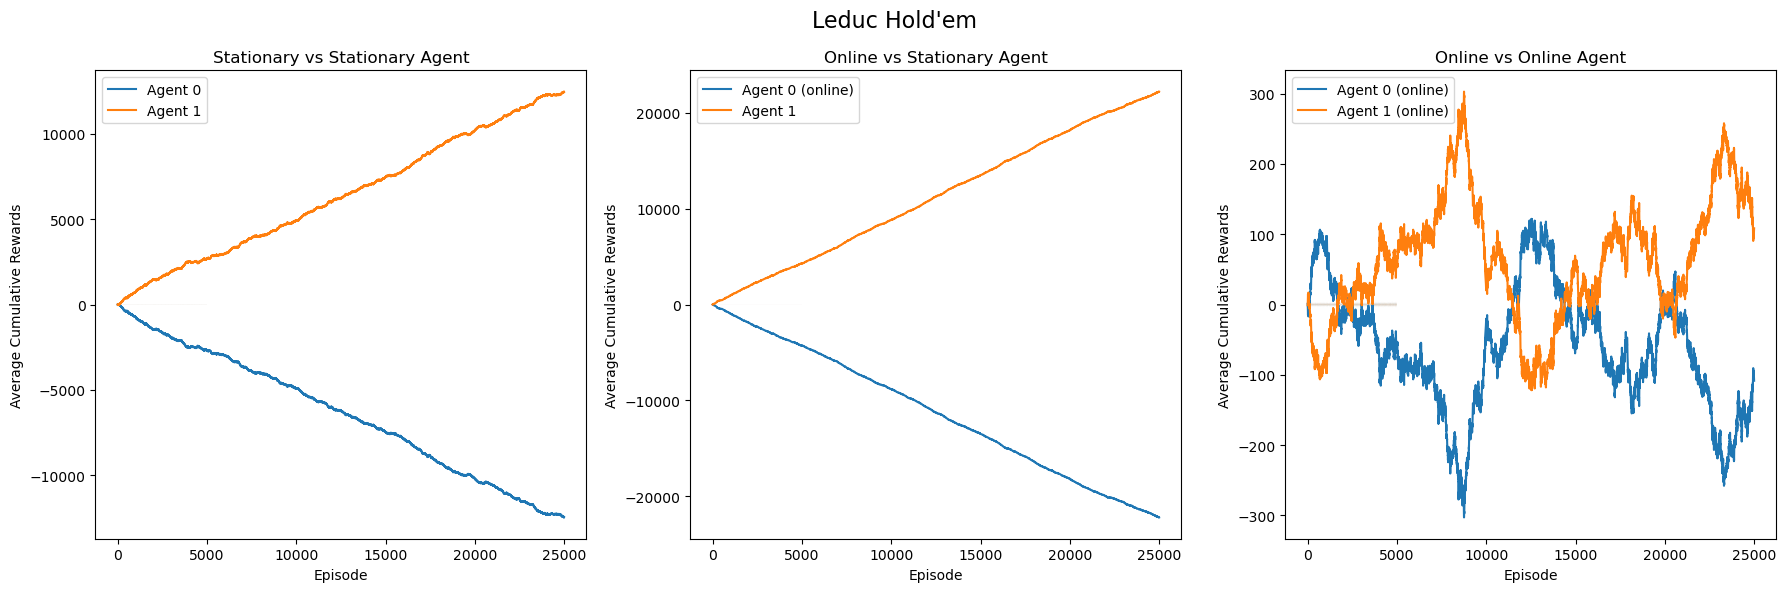

In [86]:
agent_0_cumsums = {'no_no': np.cumsum(np.array(no_no['agent_0'])), 'yes_no': np.cumsum(np.array(yes_no['agent_0'])), 'yes_yes': np.cumsum(np.array(yes_yes['agent_0']))}
agent_1_cumsums = {'no_no': np.cumsum(np.array(no_no['agent_1'])), 'yes_no': np.cumsum(np.array(yes_no['agent_1'])), 'yes_yes': np.cumsum(np.array(yes_yes['agent_1']))}

#get the mean and confidence bands 1.96 * standard error
agent_0_means = {'no_no': np.mean(np.array(no_no['agent_0']), axis=0), 'yes_no': np.mean(np.array(yes_no['agent_0']), axis=0), 'yes_yes': np.mean(np.array(yes_yes['agent_0']), axis=0)}
agent_0_conf = {'no_no': 1.96 * np.std(np.array(no_no['agent_0']), axis=0) / np.sqrt(5), 'yes_no': 1.96 * np.std(np.array(yes_no['agent_0']), axis=0) / np.sqrt(5), 'yes_yes': 1.96 * np.std(np.array(yes_yes['agent_0']), axis=0) / np.sqrt(5)}

agent_1_means = {'no_no': np.mean(np.array(no_no['agent_1']), axis=0), 'yes_no': np.mean(np.array(yes_no['agent_1']), axis=0), 'yes_yes': np.mean(np.array(yes_yes['agent_1']), axis=0)}
agent_1_conf = {'no_no': 1.96 * np.std(np.array(no_no['agent_1']), axis=0) / np.sqrt(5), 'yes_no': 1.96 * np.std(np.array(yes_no['agent_1']), axis=0) / np.sqrt(5), 'yes_yes': 1.96 * np.std(np.array(yes_yes['agent_1']), axis=0) / np.sqrt(5)}

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns for three plots side by side

# Plot 1: Cumulative Wins for 'no_no'
axs[0].plot(agent_0_cumsums['no_no'], label='Agent 0')
axs[0].plot(agent_1_cumsums['no_no'], label='Agent 1')
axs[0].fill_between(np.arange(len(agent_0_means['no_no'])), agent_0_means['no_no'] - agent_0_conf['no_no'], agent_0_means['no_no'] + agent_0_conf['no_no'], alpha=0.2)
axs[0].fill_between(np.arange(len(agent_1_means['no_no'])), agent_1_means['no_no'] - agent_1_conf['no_no'], agent_1_means['no_no'] + agent_1_conf['no_no'], alpha=0.2)
axs[0].set_xlabel('Episode')
axs[0].set_ylabel('Average Cumulative Rewards')
axs[0].set_title('Stationary vs Stationary Agent')
axs[0].legend()

# Plot 2: Cumulative Wins for 'yes_no'
axs[1].plot(agent_0_cumsums['yes_no'], label='Agent 0 (online)')
axs[1].plot(agent_1_cumsums['yes_no'], label='Agent 1')
axs[1].fill_between(np.arange(len(agent_0_means['yes_no'])), agent_0_means['yes_no'] - agent_0_conf['yes_no'], agent_0_means['yes_no'] + agent_0_conf['yes_no'], alpha=0.2)
axs[1].fill_between(np.arange(len(agent_1_means['yes_no'])), agent_1_means['yes_no'] - agent_1_conf['yes_no'], agent_1_means['yes_no'] + agent_1_conf['yes_no'], alpha=0.2)
axs[1].set_xlabel('Episode')
axs[1].set_ylabel('Average Cumulative Rewards')
axs[1].set_title('Online vs Stationary Agent')
axs[1].legend()

# Plot 3: Cumulative Wins for 'yes_yes'
axs[2].plot(agent_0_cumsums['yes_yes'], label='Agent 0 (online)')
axs[2].plot(agent_1_cumsums['yes_yes'], label='Agent 1 (online)')
axs[2].fill_between(np.arange(len(agent_0_means['yes_yes'])), agent_0_means['yes_yes'] - agent_0_conf['yes_yes'], agent_0_means['yes_yes'] + agent_0_conf['yes_yes'], alpha=0.2)
axs[2].fill_between(np.arange(len(agent_1_means['yes_yes'])), agent_1_means['yes_yes'] - agent_1_conf['yes_yes'], agent_1_means['yes_yes'] + agent_1_conf['yes_yes'], alpha=0.2)
axs[2].set_xlabel('Episode')
axs[2].set_ylabel('Average Cumulative Rewards')
axs[2].set_title('Online vs Online Agent')
axs[2].legend()

fig.suptitle('Leduc Hold\'em', fontsize=16)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()


### Texas Hold'em Training

In [87]:
env = texas_holdem_v4.env(render_mode="rgb_array")
env_name = 'texas_holdem'
gamma = 0.99

# we train for many time-steps;  as usual, you can decrease this during development / debugging.
# but make sure to restore it to 1_500_000 before submitting.
num_steps = 30000
num_saves = 5  # save models at 0%, 25%, 50%, 75% and 100% of training

replay_size = 20000
replay_prepopulate_steps = 1000

batch_size = 32
exploration = ExponentialSchedule(1.0, 0.01, 100_000)

num_layers = 3
hidden_dim = 32
target_update_freq = 100

# this should take about 90-120 minutes on a generic 4-core laptop
dqn_models, returns, lengths, losses = train_dqn_adversarial(
    env,
    num_steps,
    num_saves=num_saves,
    replay_size=replay_size,
    replay_prepopulate_steps=replay_prepopulate_steps,
    batch_size=batch_size,
    exploration=exploration,
    gamma=gamma,
    num_layers=num_layers,
    hidden_dim=hidden_dim,
    target_update_freq=target_update_freq,
)


for agent in ['agent_0', 'agent_1']:

    assert len(dqn_models[agent]) == num_saves
    assert all(isinstance(value, DQN) for value in dqn_models[agent].values())

    # saving computed models to disk, so that we can load and visualize them later.
    checkpoint = {key: dqn.custom_dump() for key, dqn in dqn_models[agent].items()}
    torch.save(checkpoint, f'checkpoint_{env_name}_{agent}.pt')

    #save the returns, lengths and losses to disk
    #os.makedirs(f'{agent}/{env_name}', exist_ok=False)
    np.save(f'{agent}/{env_name}/returns.npy', np.array(returns[agent]), allow_pickle=True)
    np.save(f'{agent}/{env_name}/lengths.npy', np.array(lengths[agent]), allow_pickle=True)
    np.save(f'{agent}/{env_name}/losses.npy', np.array(losses[agent]), allow_pickle=True)

Episode: 30000 | Steps: 1 | Return: 36.04 | Epsilon: 0.25: 100%|█| 30000/30000 [01:52<00:00, 267.82i
/tmp/ipykernel_911301/283405188.py:47: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  np.save(f'{agent}/{env_name}/returns.npy', np.array(returns[agent]), allow_pickle=True)
/tmp/ipykernel_911301/283405188.py:47: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  np.save(f

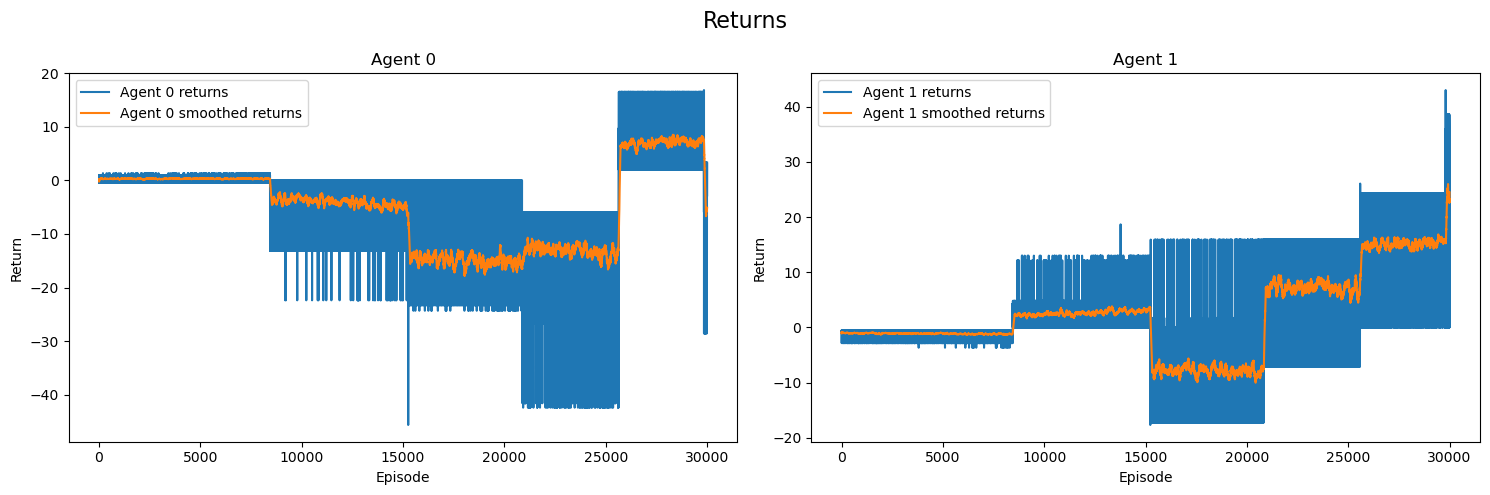

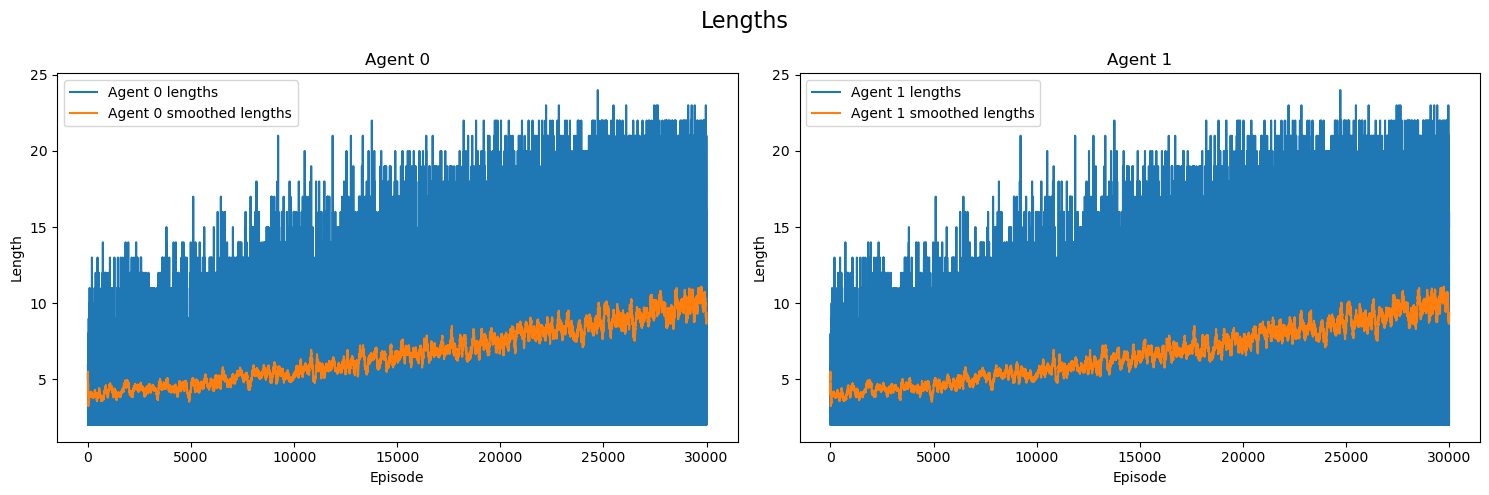

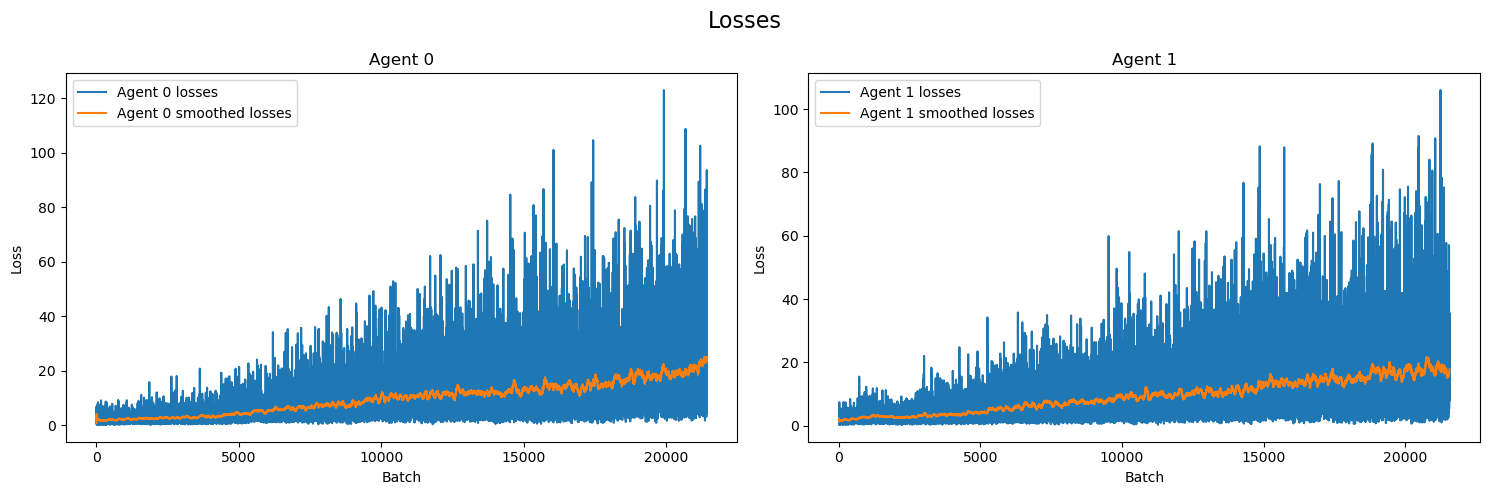

In [88]:
#read in the returns, lengths and losses from disk
returns_0 = np.load('agent_0/texas_holdem/returns.npy', allow_pickle=True)
lengths_0 = np.load('agent_0/texas_holdem/lengths.npy', allow_pickle=True)
losses_0 = np.load('agent_0/texas_holdem/losses.npy', allow_pickle=True)

returns_1 = np.load('agent_1/texas_holdem/returns.npy', allow_pickle=True)
lengths_1 = np.load('agent_1/texas_holdem/lengths.npy', allow_pickle=True)
losses_1 = np.load('agent_1/texas_holdem/losses.npy', allow_pickle=True)

window_size = 100

#smooth the returns, lengths and losses
smooth_returns_0 = rolling_average(returns_0, window_size=window_size)
smooth_lengths_0 = rolling_average(lengths_0, window_size=window_size)
smooth_losses_0 = rolling_average(losses_0, window_size=window_size)

smooth_returns_1 = rolling_average(returns_1, window_size=window_size)
smooth_lengths_1 = rolling_average(lengths_1, window_size=window_size)
smooth_losses_1 = rolling_average(losses_1, window_size=window_size)

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Agent 0 Returns
axs[0].plot(returns_0, label='Agent 0 returns')
axs[0].plot(smooth_returns_0, label='Agent 0 smoothed returns')
axs[0].set_xlabel('Episode')
axs[0].set_ylabel('Return')
axs[0].set_title('Agent 0')
axs[0].legend()

# Agent 1 Returns
axs[1].plot(returns_1, label='Agent 1 returns')
axs[1].plot(smooth_returns_1, label='Agent 1 smoothed returns')
axs[1].set_xlabel('Episode')
axs[1].set_ylabel('Return')
axs[1].set_title('Agent 1')
axs[1].legend()

fig.suptitle('Returns', fontsize=16)

# Adjust subplot layout
plt.tight_layout()

# Show the plots
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Agent 0 Lengths
axs[0].plot(lengths_0, label='Agent 0 lengths')
axs[0].plot(smooth_lengths_0, label='Agent 0 smoothed lengths')
axs[0].set_xlabel('Episode')
axs[0].set_ylabel('Length')
axs[0].set_title('Agent 0')
axs[0].legend()

# Agent 1 Lengths
axs[1].plot(lengths_1, label='Agent 1 lengths')
axs[1].plot(smooth_lengths_1, label='Agent 1 smoothed lengths')
axs[1].set_xlabel('Episode')
axs[1].set_ylabel('Length')
axs[1].set_title('Agent 1')
axs[1].legend()

fig.suptitle('Lengths', fontsize=16)

# Adjust subplot layout
plt.tight_layout()

# Show the plots
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Agent 0 Losses
axs[0].plot(losses_0, label='Agent 0 losses')
axs[0].plot(smooth_losses_0, label='Agent 0 smoothed losses')
axs[0].set_xlabel('Batch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Agent 0')
axs[0].legend()

# Agent 1 Losses
axs[1].plot(losses_1, label='Agent 1 losses')
axs[1].plot(smooth_losses_1, label='Agent 1 smoothed losses')
axs[1].set_xlabel('Batch')
axs[1].set_ylabel('Loss')
axs[1].set_title('Agent 1')
axs[1].legend()

#kake an overall title
fig.suptitle('Losses', fontsize=16)

# Adjust subplot layout
plt.tight_layout()

# Show the plots
plt.show()


### Texas Hold'em Simulation

In [89]:
env = texas_holdem_v4.env(render_mode="rgb_array")
env_name = 'texas_holdem'

agent_0_models= torch.load('checkpoint_texas_holdem_agent_0.pt')
agent_1_models= torch.load('checkpoint_texas_holdem_agent_1.pt')

no_no = {'agent_0': [], 'agent_1': []}
yes_no = {'agent_0': [], 'agent_1': []}
yes_yes = {'agent_0': [], 'agent_1': []}

for i in range(5):

    #simluate interactions between 2 non-learning agents
    inter_no_no = interact_with_online_learning(
        env, 
        agent_0_dict=agent_0_models['100_0'], 
        agent_0_online=False, 
        agent_1_dict=agent_1_models['100_0'],
        agent_1_online=False,
        num_episodes=5000,
        batch_size=32,
        gamma=0.99,
        exploration=ExponentialSchedule(1.0, 0.01, 100_000),
        replay_size=200000,
        target_update_freq=500,
        coop=False
    )

    no_no['agent_0'].append(inter_no_no['agent_0'])
    no_no['agent_1'].append(inter_no_no['agent_1'])

    #simluate interactions between 2 non-learning agents
    inter_yes_no = interact_with_online_learning(
        env, 
        agent_0_dict=agent_0_models['100_0'], 
        agent_0_online=True, 
        agent_1_dict=agent_1_models['100_0'],
        agent_1_online=False,
        num_episodes=5000,
        batch_size=32,
        gamma=0.99,
        exploration=ExponentialSchedule(1.0, 0.01, 100_000),
        replay_size=200000,
        target_update_freq=500,
        coop=False
    )

    yes_no['agent_0'].append(inter_yes_no['agent_0'])
    yes_no['agent_1'].append(inter_yes_no['agent_1'])


    #simluate interactions between 2 non-learning agents
    inter_yes_yes = interact_with_online_learning(
        env, 
        agent_0_dict=agent_0_models['100_0'], 
        agent_0_online=True, 
        agent_1_dict=agent_1_models['100_0'],
        agent_1_online=True,
        num_episodes=5000,
        batch_size=32,
        gamma=0.99,
        exploration=ExponentialSchedule(1.0, 0.01, 100_000),
        replay_size=200000,
        target_update_freq=500,
        coop=False
    )

    yes_yes['agent_0'].append(inter_yes_yes['agent_0'])
    yes_yes['agent_1'].append(inter_yes_yes['agent_1'])


100%|██████████████████████████████████████████████████████████| 5000/5000 [00:17<00:00, 289.35it/s]


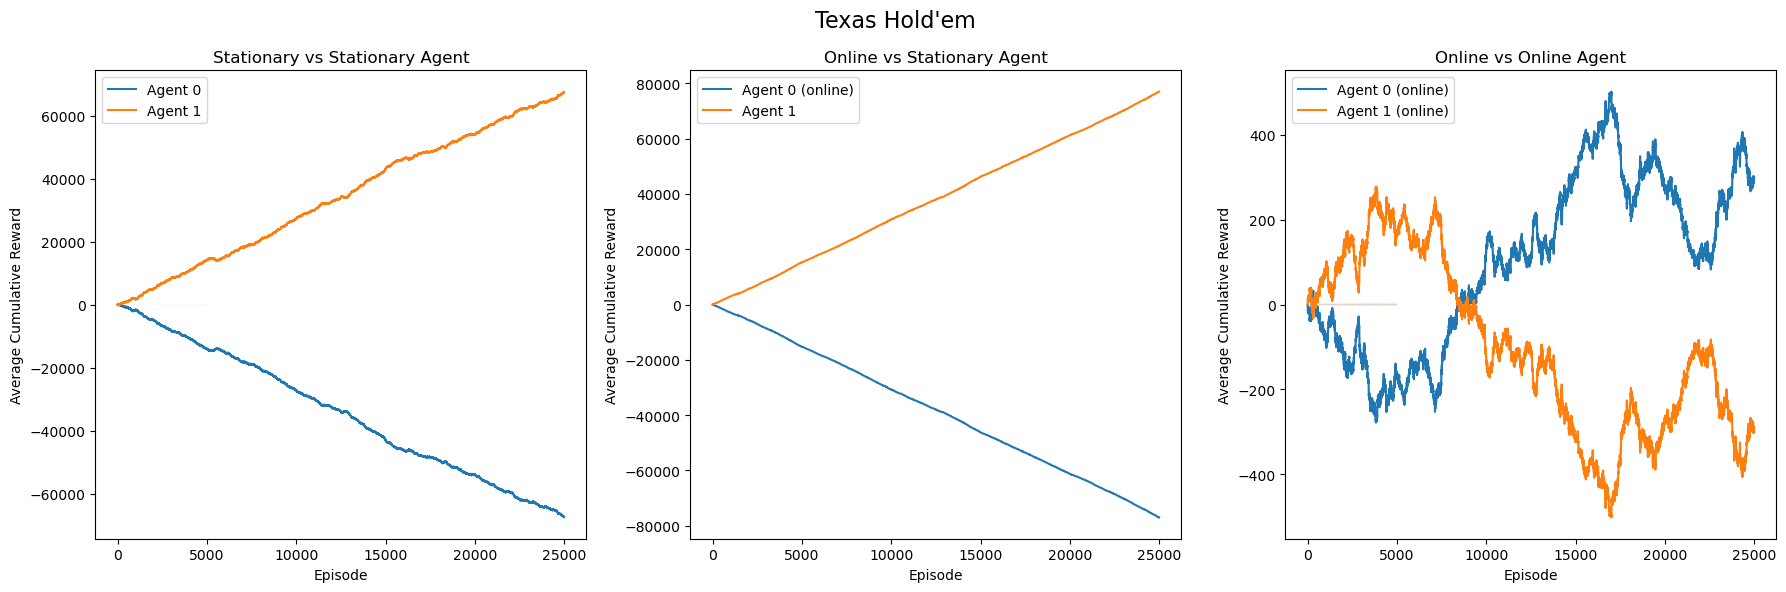

In [90]:
agent_0_cumsums = {'no_no': np.cumsum(np.array(no_no['agent_0'])), 'yes_no': np.cumsum(np.array(yes_no['agent_0'])), 'yes_yes': np.cumsum(np.array(yes_yes['agent_0']))}
agent_1_cumsums = {'no_no': np.cumsum(np.array(no_no['agent_1'])), 'yes_no': np.cumsum(np.array(yes_no['agent_1'])), 'yes_yes': np.cumsum(np.array(yes_yes['agent_1']))}

#get the mean and confidence bands 1.96 * standard error
agent_0_means = {'no_no': np.mean(np.array(no_no['agent_0']), axis=0), 'yes_no': np.mean(np.array(yes_no['agent_0']), axis=0), 'yes_yes': np.mean(np.array(yes_yes['agent_0']), axis=0)}
agent_0_conf = {'no_no': 1.96 * np.std(np.array(no_no['agent_0']), axis=0) / np.sqrt(5), 'yes_no': 1.96 * np.std(np.array(yes_no['agent_0']), axis=0) / np.sqrt(5), 'yes_yes': 1.96 * np.std(np.array(yes_yes['agent_0']), axis=0) / np.sqrt(5)}

agent_1_means = {'no_no': np.mean(np.array(no_no['agent_1']), axis=0), 'yes_no': np.mean(np.array(yes_no['agent_1']), axis=0), 'yes_yes': np.mean(np.array(yes_yes['agent_1']), axis=0)}
agent_1_conf = {'no_no': 1.96 * np.std(np.array(no_no['agent_1']), axis=0) / np.sqrt(5), 'yes_no': 1.96 * np.std(np.array(yes_no['agent_1']), axis=0) / np.sqrt(5), 'yes_yes': 1.96 * np.std(np.array(yes_yes['agent_1']), axis=0) / np.sqrt(5)}

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1 row, 3 columns for three plots side by side

# Plot 1: Cumulative Wins for 'no_no'
axs[0].plot(agent_0_cumsums['no_no'], label='Agent 0')
axs[0].plot(agent_1_cumsums['no_no'], label='Agent 1')
axs[0].fill_between(np.arange(len(agent_0_means['no_no'])), agent_0_means['no_no'] - agent_0_conf['no_no'], agent_0_means['no_no'] + agent_0_conf['no_no'], alpha=0.2)
axs[0].fill_between(np.arange(len(agent_1_means['no_no'])), agent_1_means['no_no'] - agent_1_conf['no_no'], agent_1_means['no_no'] + agent_1_conf['no_no'], alpha=0.2)
axs[0].set_xlabel('Episode')
axs[0].set_ylabel('Average Cumulative Reward')
axs[0].set_title('Stationary vs Stationary Agent')
axs[0].legend()

# Plot 2: Cumulative Wins for 'yes_no'
axs[1].plot(agent_0_cumsums['yes_no'], label='Agent 0 (online)')
axs[1].plot(agent_1_cumsums['yes_no'], label='Agent 1')
axs[1].fill_between(np.arange(len(agent_0_means['yes_no'])), agent_0_means['yes_no'] - agent_0_conf['yes_no'], agent_0_means['yes_no'] + agent_0_conf['yes_no'], alpha=0.2)
axs[1].fill_between(np.arange(len(agent_1_means['yes_no'])), agent_1_means['yes_no'] - agent_1_conf['yes_no'], agent_1_means['yes_no'] + agent_1_conf['yes_no'], alpha=0.2)
axs[1].set_xlabel('Episode')
axs[1].set_ylabel('Average Cumulative Reward')
axs[1].set_title('Online vs Stationary Agent')
axs[1].legend()

# Plot 3: Cumulative Wins for 'yes_yes'
axs[2].plot(agent_0_cumsums['yes_yes'], label='Agent 0 (online)')
axs[2].plot(agent_1_cumsums['yes_yes'], label='Agent 1 (online)')
axs[2].fill_between(np.arange(len(agent_0_means['yes_yes'])), agent_0_means['yes_yes'] - agent_0_conf['yes_yes'], agent_0_means['yes_yes'] + agent_0_conf['yes_yes'], alpha=0.2)
axs[2].fill_between(np.arange(len(agent_1_means['yes_yes'])), agent_1_means['yes_yes'] - agent_1_conf['yes_yes'], agent_1_means['yes_yes'] + agent_1_conf['yes_yes'], alpha=0.2)
axs[2].set_xlabel('Episode')
axs[2].set_ylabel('Average Cumulative Reward')
axs[2].set_title('Online vs Online Agent')
axs[2].legend()

fig.suptitle('Texas Hold\'em', fontsize=16)

# Adjust layout to prevent overlapping
plt.tight_layout()

# Show the plots
plt.show()
